# Deconvolution algorithm controlled by the accumulator 

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [3]:
import FEE as FE

In [4]:
import time

In [5]:
import pandas as pd

In [6]:
from coreFunctions import wait

In [7]:
from Database import loadDB

## Revised on:

In [8]:
print(time.strftime("%d/%m/%Y"))

13/11/2016


In [9]:
print(time.strftime("%H:%M:%S"))

11:07:20


###  Code exercized

In [8]:
!pep8 ../../Sierpe/FEE.py

/bin/sh: pep8: command not found


In [8]:
!pyflakes ../../Sierpe/FEE.py

### Monte Carlo data

1. Running on electrons of fixed energy (40, 1250, 2500 keV)  in the center of chamber.
2. Nominal yield factor in current NEW conditions (7 bar, 7 kV in gate) is 574 photons/e
3. Monte Carlo yield factor 690 photons/e
4. Running of Kripton, Na, Tl, with yield factor 574 photons/e

In [11]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


#### List the files

In [12]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Na_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.1250.0keV.z250mm.next_10.root.h5
electrons.1250.0keV.z250mm.next_100.root.h5
electrons.1250.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10.root.h5
electrons.2500.0keV.z250mm.next_100.root.h5
electrons.2500.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10.root.h5
electrons.40.0keV.z250mm.next_100.root.h5
electrons.40.0keV.z250mm.next_1000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5
run_2609_kr.root.h5
run_2644.gdc1next.000.next1el_2644.root.h5
run_2644.gdc1next.001.next1el_2644.root.h5
run_2644.gdc1next.003.next1el_2644.roo

### Files

#### Kripton Na-22 and Th at 7bar 

In [18]:
kr7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5','r+')

In [19]:
na7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5','r+')

In [20]:
Tl7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5','r+')

#### Electrons of fixed energy

In [10]:
e2500 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.2500.0keV.z250mm.next_1000.root.h5','r+')

In [22]:
e1250 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.1250.0keV.z250mm.next_1000.root.h5','r+')

In [23]:
e40 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

## SIMULATING THE EFFECT OF ELECTRONICS OVER MC DATA

### PROCEDURE

1. Read MCRD (bins of 1 ns).
2. Convolute with SPE response to form a signal_i (units of A)
3. Decimate the signal.
4. Simulate the effect of the filter.

In [11]:
def fee_response(pmtrd, event=0):
    """
    input: pmtrd vector
    returns: a data frame with the PMT waveforms
    """
    spe = FE.SPE()
    fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
    NPMT = pmtrd.shape[1]
    
    RWF = []
    BLRX = []
    for pmt in range(NPMT):
        signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event,pmt])  # in current units  
        signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
        signal_fee = FE.signal_v_fee(fee, signal_d)*FE.v_to_adc()  #in adc counts
        signal_daq = FE.noise_adc(fee, signal_fee)
        signal_blr = signal_d*FE.i_to_adc()
        
        RWF.append(FE.OFFSET - signal_daq)
        #RWF.append(signal_daq)
        BLRX.append(signal_blr)
    
    return np.array(RWF), np.array(BLRX)

#### Electrons of 40 keV

In [27]:
RWF, BLRX = fee_response(e40.root.pmtrd, event=0) 

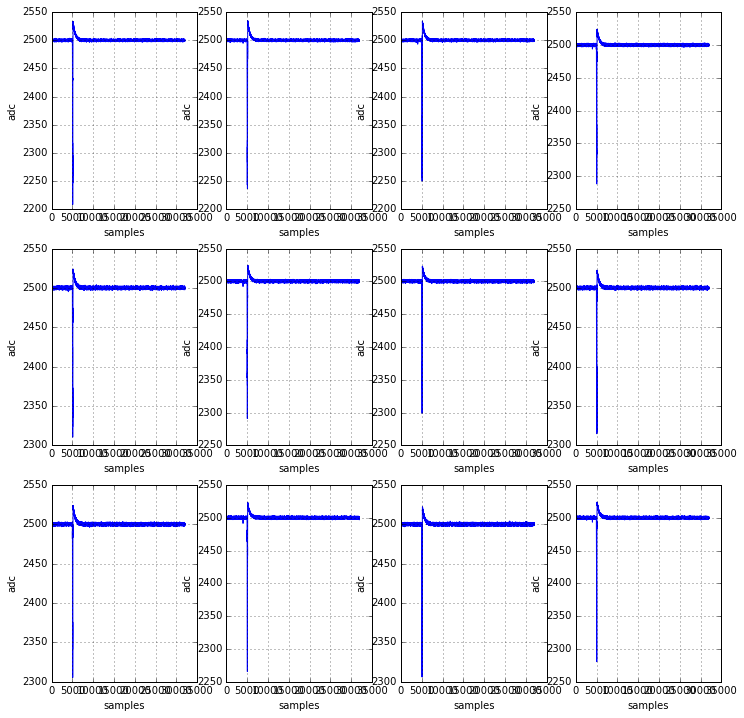

In [28]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=False, window_size=800)

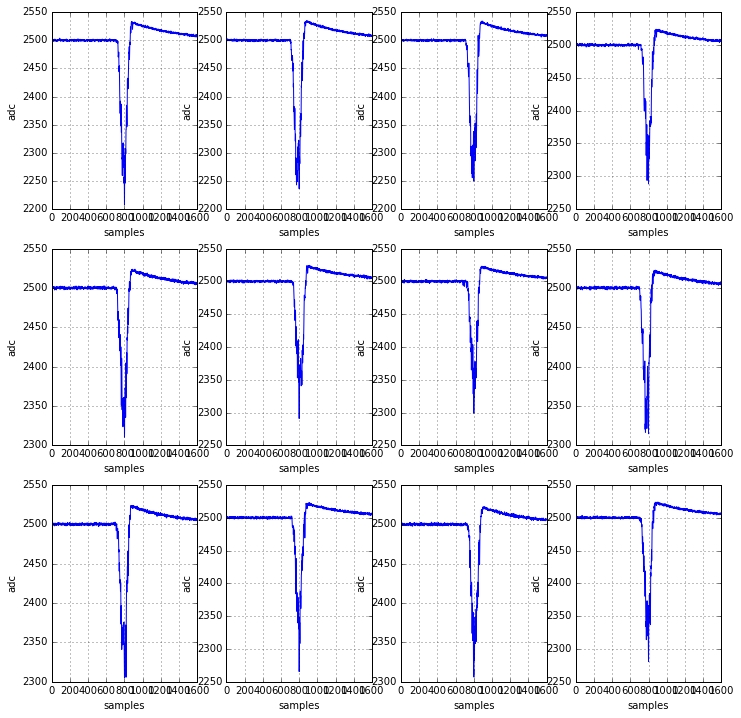

In [29]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=800)

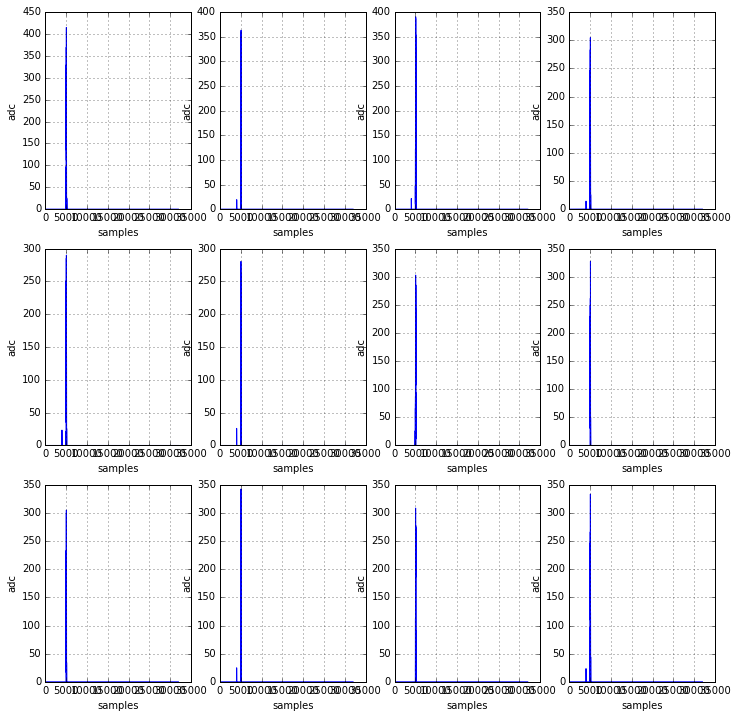

In [30]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=False, window_size=800)

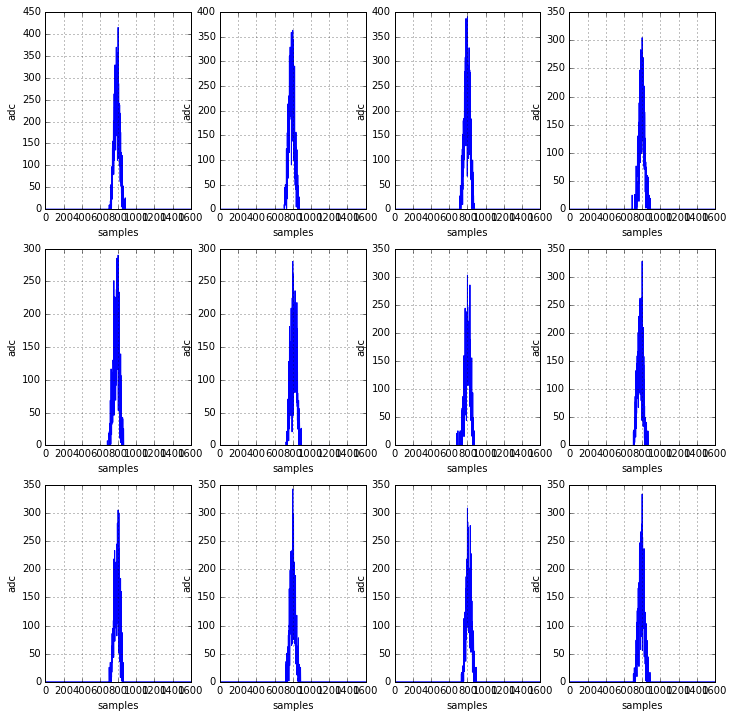

In [31]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=True, window_size=800)

#### True energy in pes (electrons of 40 keV nominal gain ¡)

In [36]:
e40DF = wfm.get_energy(e40.root.pmtrd, event_list=[0])

In [37]:
e40DF

0       1       2      3      4      5      6      7      8      9   \
0  1210.0  1263.0  1195.0  881.0  857.0  861.0  824.0  820.0  864.0  831.0   

      10     11  
0  814.0  843.0

#### True energy in pes (Kripton 7 kV t bar)

In [38]:
eKr7barDF = wfm.get_energy(kr7bar.root.pmtrd, event_list=[0]) 

In [39]:
eKr7barDF

0      1      2      3      4      5      6      7      8      9   \
0  854.0  914.0  987.0  692.0  692.0  717.0  706.0  675.0  666.0  652.0   

      10     11  
0  683.0  672.0

In [40]:
eKr7barDF/e40DF

0         1         2         3         4         5         6   \
0  0.705785  0.723674  0.825941  0.785471  0.807468  0.832753  0.856796   

         7         8         9         10        11  
0  0.823171  0.770833  0.784597  0.839066  0.797153

## Deconvolution

In [20]:
import BLR as blr

### Discharge function

In [12]:
def discharge_acum(length_d=5000, tau=2500, compress=0.005):
    t_discharge = np.arange(0,length_d,1,dtype=np.double)
    discharge_curve = compress*(1-1/(1+np.exp(-(t_discharge-length_d/2)/tau)))+(1-compress)
    return discharge_curve


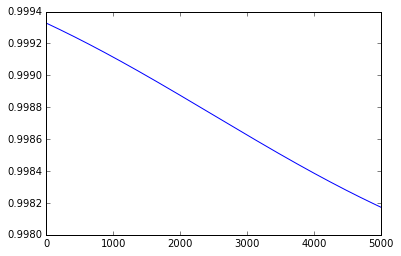

In [221]:
plt.plot(discharge_acum(length_d=5000, tau=2500, compress=0.0025))

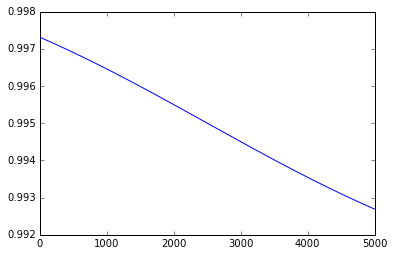

In [235]:
plt.plot(blr.discharge_acum(length_d=5000, tau=2500, compress=0.01))

### Accumulator controlled BLR

In [13]:
def deconvolve_signal_acum(signal_i, n_baseline=500, noise_rms= 0.8,
                      coef_clean=2.905447E-06, coef_blr=1.632411E-03, 
                      thr_trigger=5, thr_acum=1000, coeff_acum = 0.9995,
                      acum_discharge_length = 5000, acum_tau=2500, acum_compress=0.0025,
                      filter_c=True):

    """
    The accumulator approach by Master VHB

    """
    
    coef = coef_blr
    nm = n_baseline
    
    len_signal_daq = len(signal_i)
    
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    pulse_on = np.zeros(len_signal_daq, dtype=np.int8)
    j_reg = np.zeros(len_signal_daq, dtype=np.double)
    trigger = np.zeros(len_signal_daq, dtype=np.double)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    
    # signal_daq in floats
    signal_daq = signal_i.astype(float)
    # baseline and noise. Start the MAU with the value of the baseline
    baseline = np.mean(signal_daq[0:nm])
    noise_rms = np.std(signal_daq[0:nm],ddof=1)
    
    
    
    # change sign and subtract baseline
    signal_daq =  baseline - signal_daq
    
    # clean the signal_daq
    if filter_c==True:
        b_cf, a_cf = signal.butter(1, coef_clean, 'high', analog=False);
        signal_daq = signal.lfilter(b_cf,a_cf,signal_daq)
        

    discharge_curve = discharge_acum(length_d=acum_discharge_length, tau=acum_tau, 
                                compress=acum_compress)
    j=0
 
    # BLR
    signal_r[0:nm] = signal_daq[0:nm] 
    p_on = 0
    
    MAU[0:nm] = np.mean(signal_daq[0:nm])
    
    print ("baseline = {}, noise (LSB_rms) = {} MAU[nm] ={} ".format(
            baseline, noise_rms, MAU[nm]))
    
    trigger_line = thr_trigger*noise_rms
    for k in range(nm,len_signal_daq): 
        
        
        pulse_on[k] = p_on
        trigger[k] = trigger_line
        
        # update recovered signal
        signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
        
        # condition: raw signal raises above trigger line 
        if (signal_daq[k] > trigger_line) or (acum[k-1] > thr_acum):
            
            if p_on == 0:
                p_on = 1
                 # take the value of the offset as the baseline average in k-1
                offset = MAU[k-1] 
                #print ("k = {} offset = {}, trigger line = {}, signal_daq[k] ={} acum[k-1] = {}".\
                #       format(k, offset, trigger_line,signal_daq[k],acum[k-1] ))
            
            MAU[k] = MAU[k-1]  # slide the MAU
            
            #signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            # update de accumulator until it drops below thr_acum
            #acum[k] = acum[k-1] + signal_daq[k] - MAU[k]
            acum[k] = acum[k-1] + signal_daq[k] 
           
                   
        else:
            if p_on == 1:
                p_on = 0
                j = 0
            
            MAU[k] = np.mean(signal_daq[k-nm:k])  # update the baseline
                
            #signal_r[k] = signal_daq[k]
            # deplete the accumulator before or after the signal to avoid runoffs
            #if acum[k-1]>0:
            #    acum[k]=acum[k-1]*coeff_acum
            
            # discharge acumulator
            
            if acum[k-1]>1:
                acum[k] = acum[k-1]*discharge_curve[j]
                if j<acum_discharge_length-1:
                    j=j+1
                else:
                    j=acum_discharge_length-1
            else:
                acum[k]=0
                j=0
            
#             if k > 4977 and k < 4982:
#                 print ("k = {}, signal_daq[k] ={} MAU[k] ={}".\
#                        format(k, signal_daq[k],MAU[k],  ))
                
#                 print ("j = {} discharge_curve[j] = {}, acum[k-1] = {} acum[k] = {} ".\
#                        format(j, discharge_curve[j],acum[k-1],acum[k]))
            
#             if k > 6600 and k < 6610:
#                 print ("k = {}, signal_daq[k] ={} MAU[k] ={}".\
#                        format(k, signal_daq[k],MAU[k],  ))
                
#                 print ("j = {} discharge_curve[j] = {}, acum[k-1] = {} acum[k] = {} ".\
#                        format(j, discharge_curve[j],acum[k-1],acum[k]))
            
                
        j_reg[k]=j 
    
    BLR={}
    BLR['acum'] = acum
    BLR['pulse_on'] = pulse_on
    BLR['signal_daq'] = signal_daq
    BLR['signal_r'] = signal_r
    BLR['MAU'] = MAU
    BLR['j_reg'] = j_reg
    BLR['trigger'] = trigger
    
    return pd.DataFrame(BLR)

In [244]:
RWF, BLRX = fee_response(e40.root.pmtrd, event=0) 

In [245]:
signal_daq = RWF[0]

In [22]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
freq_zero = 1./(fee.R1*fee.C1)
freq_zerod = freq_zero/(fee.f_sample*np.pi)
coef_c = freq_zerod
coef_blr = fee.freq_LHPFd*np.pi
print('coef_c = {}'.format(coef_c))
print('coef_blr = {}'.format(coef_blr)) 

coef_c = 1.87116159952e-06
coef_blr = 0.00192400951255


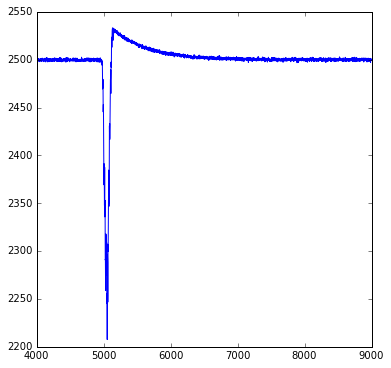

In [247]:
plt.figure(figsize=(6, 6))
xmin=4000
xmax=9000
plt.plot(range(xmin,xmax),signal_daq[xmin:xmax])

In [248]:
BLR = deconvolve_signal_acum(signal_daq, n_baseline=500, noise_rms= 0.8,
                      coef_clean=coef_c, coef_blr=coef_blr, 
                      thr_trigger=5, thr_acum=1000, coeff_acum = 0.9995,
                      acum_discharge_length = 5000, acum_tau=2500, acum_compress=0.0025,
                      filter_c=True)


baseline = 2499.9517644, noise (LSB_rms) = 0.87155820818 MAU[nm] =0.0 


In [249]:
BLR2 = blr.deconvolve_signal_acum(signal_daq, n_baseline=500, noise_rms= 0.8,
                      coef_clean=coef_c, coef_blr=coef_blr, 
                      thr_trigger=5, thr_acum=1000, coeff_acum = 0.9995,
                      acum_discharge_length = 5000, acum_tau=2500, acum_compress=0.01,
                      filter_c=True)

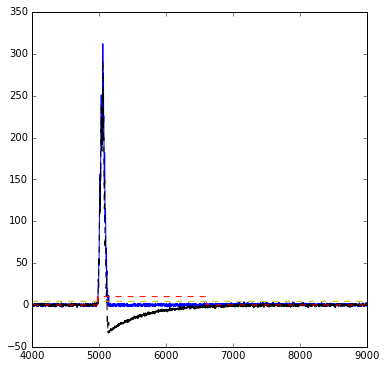

In [250]:
plt.figure(figsize=(6, 6))
xmin=4000
xmax=9000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

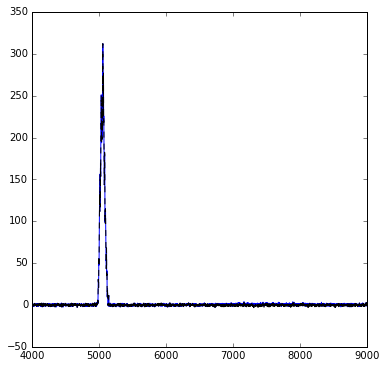

In [251]:
plt.figure(figsize=(6, 6))
xmin=4000
xmax=9000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR2['signal_r'][xmin:xmax],'k--')

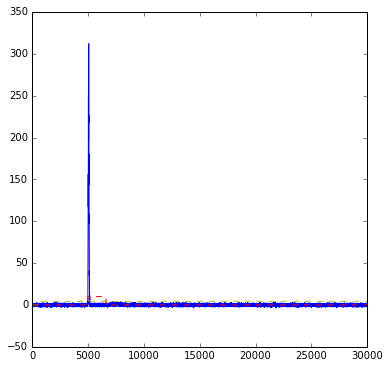

In [252]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=30000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

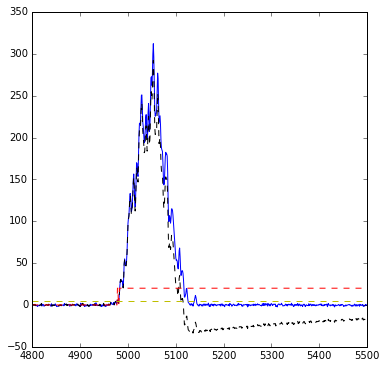

In [253]:
plt.figure(figsize=(6, 6))
xmin=4800
xmax=5500
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*20,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)

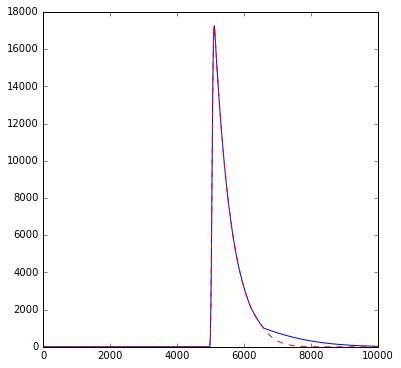

In [254]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=10000
plt.plot(range(xmin,xmax),BLR.acum[xmin:xmax])
plt.plot(range(xmin,xmax),BLR2.acum[xmin:xmax],'r--', linewidth=1)

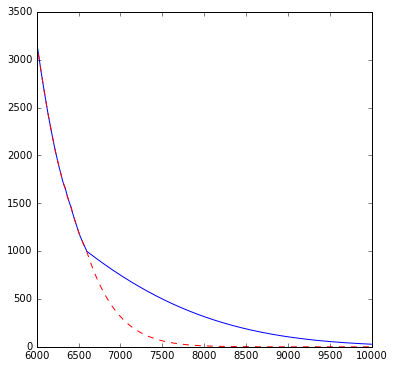

In [255]:
plt.figure(figsize=(6, 6))
xmin=6000
xmax=10000
plt.plot(range(xmin,xmax),BLR.acum[xmin:xmax])
plt.plot(range(xmin,xmax),BLR2.acum[xmin:xmax],'r--', linewidth=1)

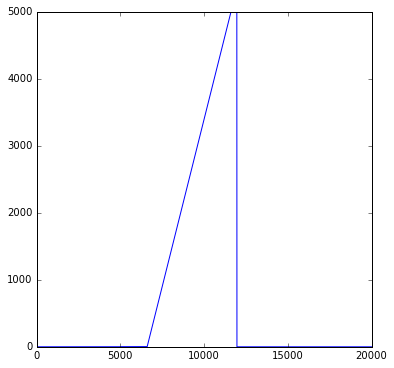

In [256]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=20000
plt.plot(range(xmin,xmax),BLR.j_reg[xmin:xmax])

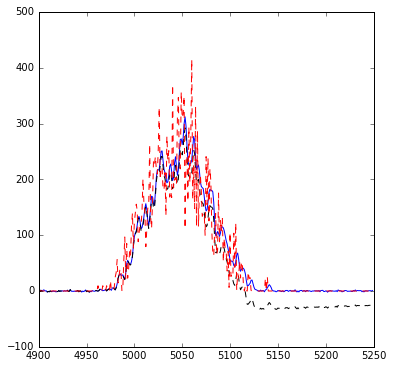

In [257]:
plt.figure(figsize=(6, 6))
xmin=4900
xmax=5250
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax],'r--')

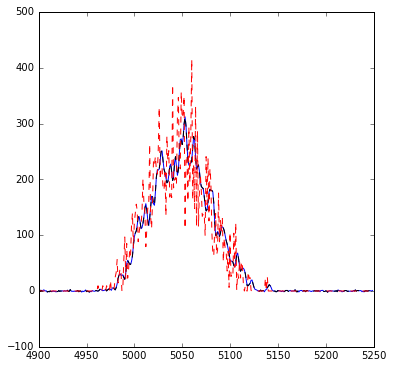

In [258]:
plt.figure(figsize=(6, 6))
xmin=4900
xmax=5250
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR2['signal_r'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax],'r--')

In [259]:
xmin=4900
xmax=5250
print('True energy in adc counts (BLRX[xmin:xmax] = {}, BLR[:] = {} rec energy = {})'.format(
    np.sum(BLRX[0][xmin:xmax]), np.sum(BLRX[0]), np.sum(BLR.signal_r[xmin:xmax]) ))
print('True energy in pes = {}, ratio (adc_to_pes) = {})'.format(e40DF[0][0],
                                                                 np.sum(BLRX[0])/e40DF[0][0] ))

True energy in adc counts (BLRX[xmin:xmax] = 19874.1902873, BLR[:] = 19874.1902873 rec energy = 19833.546605)
True energy in pes = 1210.0, ratio (adc_to_pes) = 16.4249506507)


In [95]:
xmin=4950
xmax=5150
np.sum(BLR.signal_r[xmin:xmax])

19823.530973171022

In [18]:
def blr_stats(pmtrd, event_list=[0], xmin=4900, xmax=5150, pmtid=0, plot=False):
    ER = np.zeros(len(event_list), dtype=np.double)
    
    for i, event in enumerate(event_list):
        print('event = {}'.format(event))
        RWF, BLRX = fee_response(pmtrd, event=event)
        BLR = blr.deconvolve_signal_acum(RWF[pmtid], n_baseline=500, noise_rms= 0.8,
                      coef_clean=coef_c, coef_blr=coef_blr, 
                      thr_trigger=5, thr_acum=1000, coeff_acum = 0.9995,
                      acum_discharge_length = 5000, acum_tau=2500, acum_compress=0.01,
                      filter_c=True)

        
        energy_mea=np.sum(BLR.signal_r[xmin:xmax])
        energy_in=np.sum(BLRX[pmtid][xmin:xmax])
        ER[i] = 100*abs(energy_mea - energy_in)/energy_in
        
        if plot == True:
            plt.figure(figsize=(6, 6))
            plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
            plt.plot(range(xmin,xmax),BLRX[pmtid][xmin:xmax],'r--', linewidth=1)
            print('Input Energy = {}'.format(energy_in))
            plt.show()
            print('Reconstructed Energy = {}'.format(energy_mea))
            print('Error in Energy Computation (%) = {}'.format(ER[i]))
            wait()
    return ER
  

event = 0
Input Energy = 19874.1902873


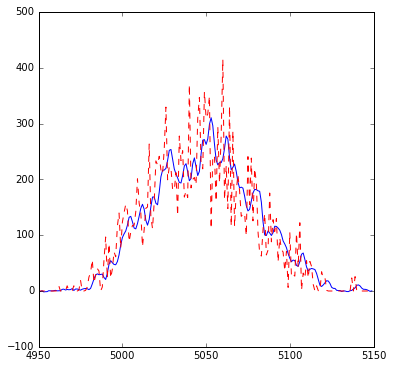

Reconstructed Energy = 19864.3862087
Error in Energy Computation (%) = 0.0493307072751
Press a key...
event = 1
Input Energy = 20863.2099178


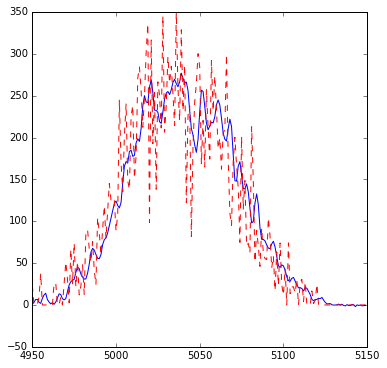

Reconstructed Energy = 20829.1970586
Error in Energy Computation (%) = 0.163027929613
Press a key...
event = 2
Input Energy = 21082.5573131


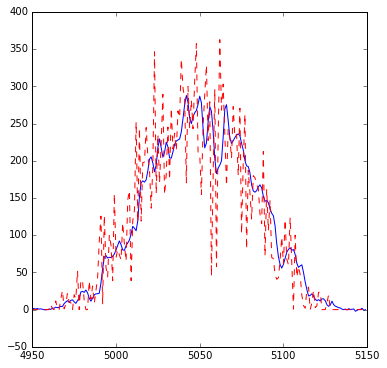

Reconstructed Energy = 21068.3392983
Error in Energy Computation (%) = 0.0674397066857
Press a key...
event = 3
Input Energy = 20413.0076922


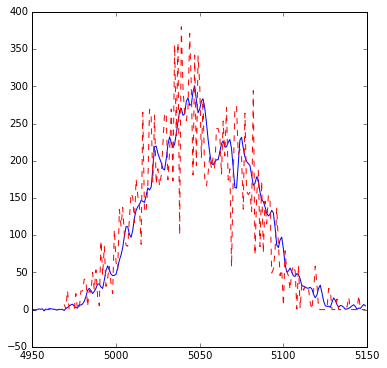

Reconstructed Energy = 20399.2692132
Error in Energy Computation (%) = 0.0673025712281
Press a key...
event = 4
Input Energy = 20718.940516


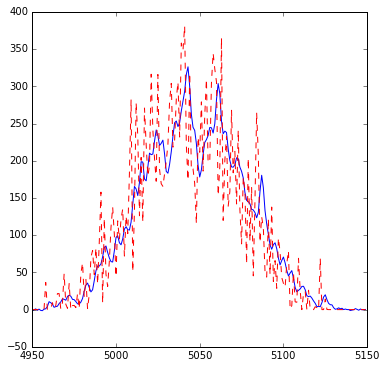

Reconstructed Energy = 20712.5731254
Error in Energy Computation (%) = 0.030732221477
Press a key...
event = 5
Input Energy = 20270.3683006


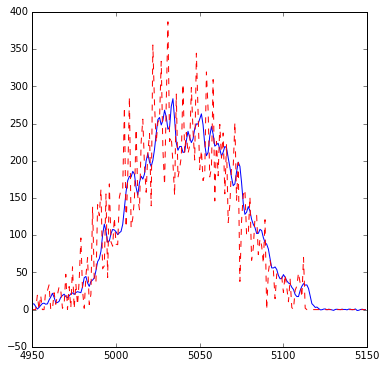

Reconstructed Energy = 20319.6404854
Error in Energy Computation (%) = 0.243074936255
Press a key...
event = 6
Input Energy = 20300.8672965


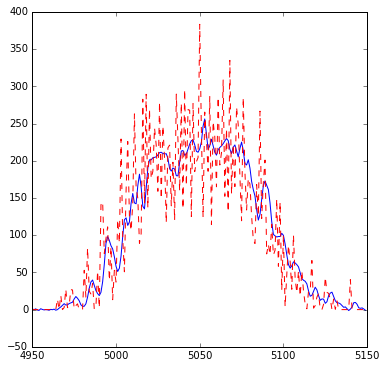

Reconstructed Energy = 20296.9467652
Error in Energy Computation (%) = 0.0193121371656
Press a key...
event = 7
Input Energy = 19699.6594203


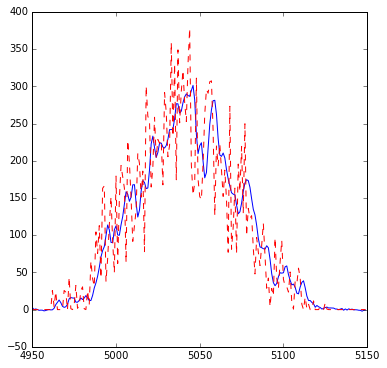

Reconstructed Energy = 19687.01435
Error in Energy Computation (%) = 0.064189283442
Press a key...
event = 8
Input Energy = 20380.3607001


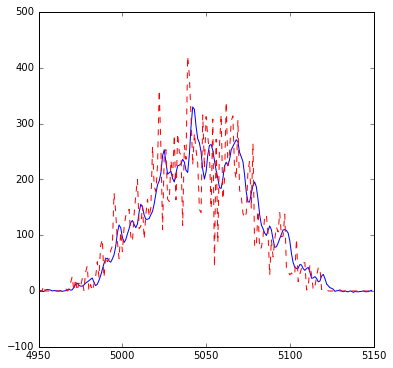

Reconstructed Energy = 20363.7826491
Error in Energy Computation (%) = 0.0813432663739
Press a key...
event = 9
Input Energy = 20228.3180926


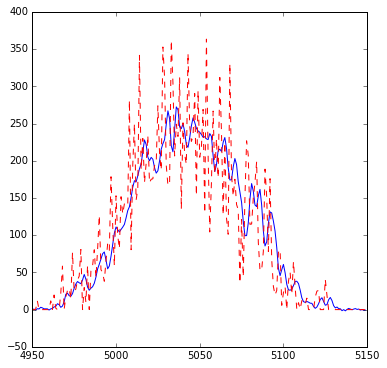

Reconstructed Energy = 20211.616173
Error in Energy Computation (%) = 0.0825670208475
Press a key...


In [261]:
ER = blr_stats(e40.root.pmtrd, event_list=range(10), xmin=4950, xmax=5150, pmtid=0, plot=True)

In [262]:
ER = blr_stats(e40.root.pmtrd, event_list=range(100), xmin=4950, xmax=5150, pmtid=0, plot=False)

event = 0
event = 1
event = 2
event = 3
event = 4
event = 5
event = 6
event = 7
event = 8
event = 9
event = 10
event = 11
event = 12
event = 13
event = 14
event = 15
event = 16
event = 17
event = 18
event = 19
event = 20
event = 21
event = 22
event = 23
event = 24
event = 25
event = 26
event = 27
event = 28
event = 29
event = 30
event = 31
event = 32
event = 33
event = 34
event = 35
event = 36
event = 37
event = 38
event = 39
event = 40
event = 41
event = 42
event = 43
event = 44
event = 45
event = 46
event = 47
event = 48
event = 49
event = 50
event = 51
event = 52
event = 53
event = 54
event = 55
event = 56
event = 57
event = 58
event = 59
event = 60
event = 61
event = 62
event = 63
event = 64
event = 65
event = 66
event = 67
event = 68
event = 69
event = 70
event = 71
event = 72
event = 73
event = 74
event = 75
event = 76
event = 77
event = 78
event = 79
event = 80
event = 81
event = 82
event = 83
event = 84
event = 85
event = 86
event = 87
event = 88
event = 89
event = 90
event = 9

(array([ 16.,  22.,  14.,  12.,   8.,   9.,   7.,   2.,   6.,   4.]),
 array([  1.19932061e-04,   2.77063980e-02,   5.52928640e-02,
          8.28793300e-02,   1.10465796e-01,   1.38052262e-01,
          1.65638728e-01,   1.93225194e-01,   2.20811660e-01,
          2.48398126e-01,   2.75984592e-01]),
 <a list of 10 Patch objects>)

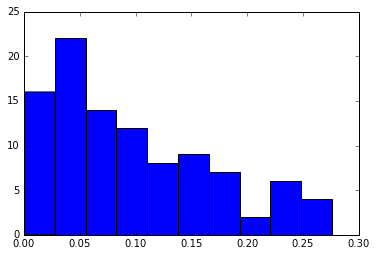

In [263]:
plt.hist(ER)

event = 0
Input Energy = 20735.9714787


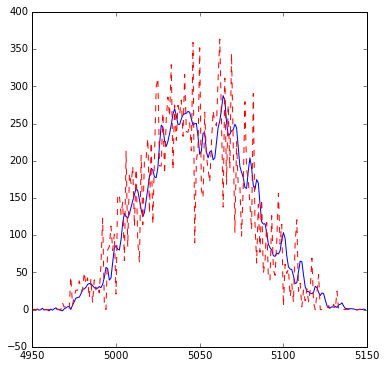

Reconstructed Energy = 20750.8537143
Error in Energy Computation (%) = 0.0717701392179
Press a key...


In [264]:
ER = blr_stats(e40.root.pmtrd, event_list=range(1), xmin=4950, xmax=5150, pmtid=1, plot=True)

In [265]:
ER = blr_stats(e40.root.pmtrd, event_list=range(100), xmin=4950, xmax=5150, pmtid=1, plot=False)

event = 0
event = 1
event = 2
event = 3
event = 4
event = 5
event = 6
event = 7
event = 8
event = 9
event = 10
event = 11
event = 12
event = 13
event = 14
event = 15
event = 16
event = 17
event = 18
event = 19
event = 20
event = 21
event = 22
event = 23
event = 24
event = 25
event = 26
event = 27
event = 28
event = 29
event = 30
event = 31
event = 32
event = 33
event = 34
event = 35
event = 36
event = 37
event = 38
event = 39
event = 40
event = 41
event = 42
event = 43
event = 44
event = 45
event = 46
event = 47
event = 48
event = 49
event = 50
event = 51
event = 52
event = 53
event = 54
event = 55
event = 56
event = 57
event = 58
event = 59
event = 60
event = 61
event = 62
event = 63
event = 64
event = 65
event = 66
event = 67
event = 68
event = 69
event = 70
event = 71
event = 72
event = 73
event = 74
event = 75
event = 76
event = 77
event = 78
event = 79
event = 80
event = 81
event = 82
event = 83
event = 84
event = 85
event = 86
event = 87
event = 88
event = 89
event = 90
event = 9

(array([ 32.,  25.,  19.,   8.,   8.,   6.,   0.,   1.,   0.,   1.]),
 array([ 0.00060128,  0.03762648,  0.07465168,  0.11167689,  0.14870209,
         0.18572729,  0.2227525 ,  0.2597777 ,  0.2968029 ,  0.33382811,
         0.37085331]),
 <a list of 10 Patch objects>)

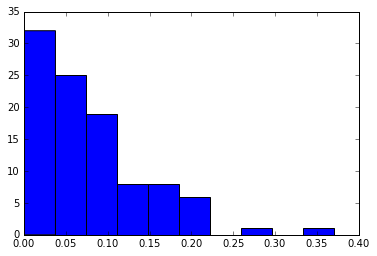

In [266]:
plt.hist(ER)

### Electrons of 1250 MeV

In [267]:
RWF, BLRX = fee_response(e1250.root.pmtrd, event=0) 

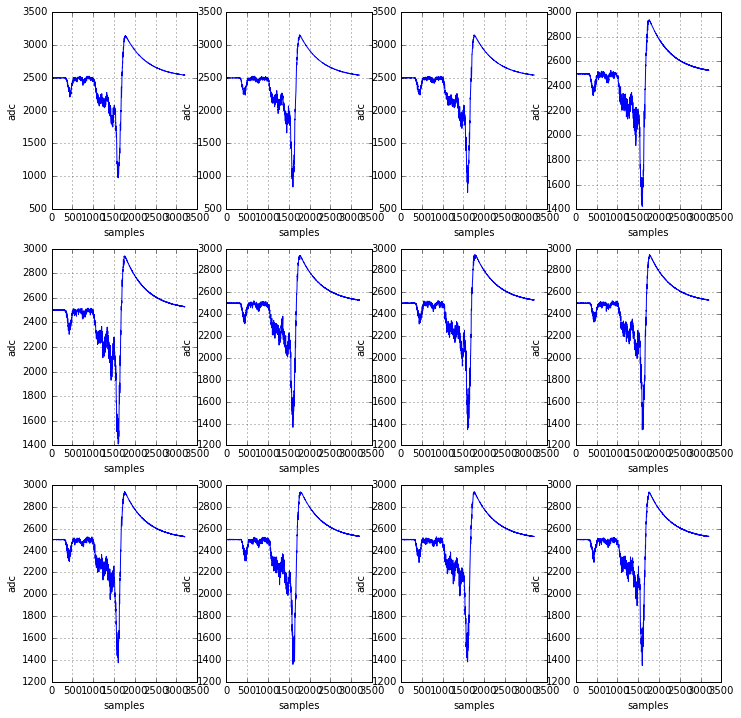

In [268]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=1600)

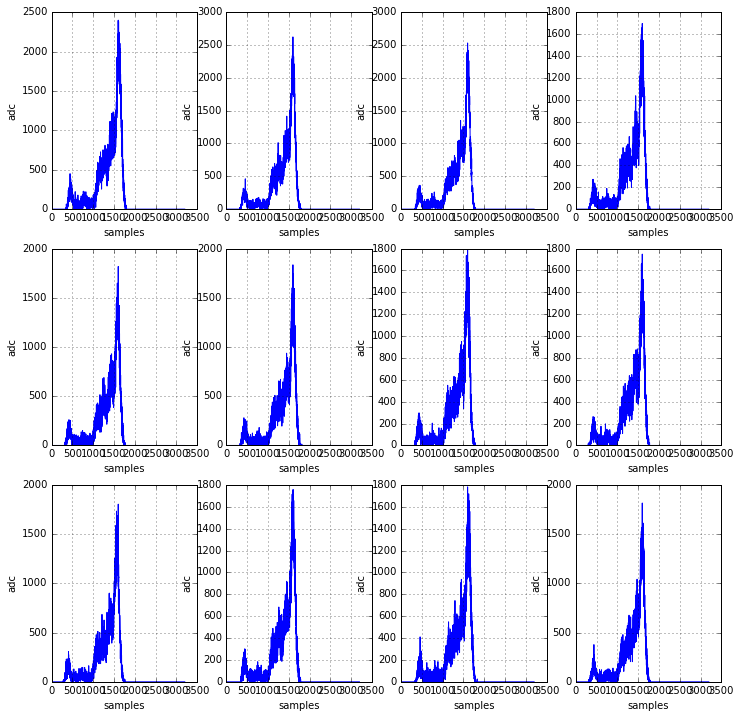

In [269]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=True, window_size=1600)

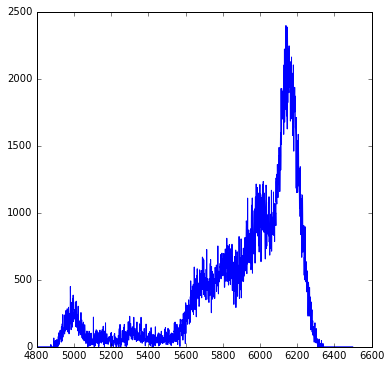

In [270]:
plt.figure(figsize=(6, 6))
xmin=4800
xmax=6500
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax])

event = 0
Input Energy = 629974.086925


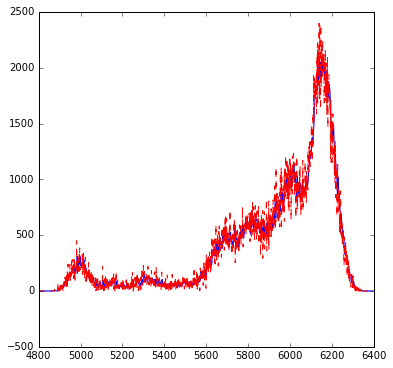

Reconstructed Energy = 630043.059296
Error in Energy Computation (%) = 0.0109484456952
Press a key...


In [271]:
ER = blr_stats(e1250.root.pmtrd, event_list=range(1), xmin=4800, xmax=6400, pmtid=0, plot=True)

event = 0
Input Energy = 630329.470288


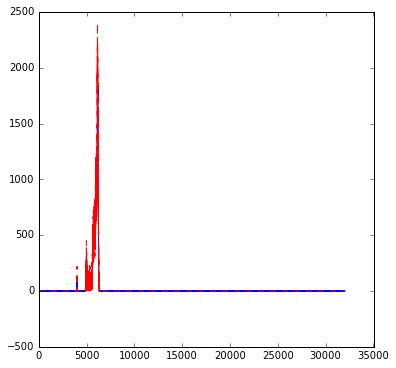

Reconstructed Energy = 629106.858735
Error in Energy Computation (%) = 0.193963888779
Press a key...


In [272]:
ER = blr_stats(e1250.root.pmtrd, event_list=range(1), xmin=0, xmax=32000, pmtid=0, plot=True)

#### NB, one cannot add the whole waveform even if BLR is perfect, since in this case one if affected by noise accumulation. Comparison must be made in the region signal!

### Electrons of 2500 keV

In [14]:
RWF, BLRX = fee_response(e2500.root.pmtrd, event=0) 

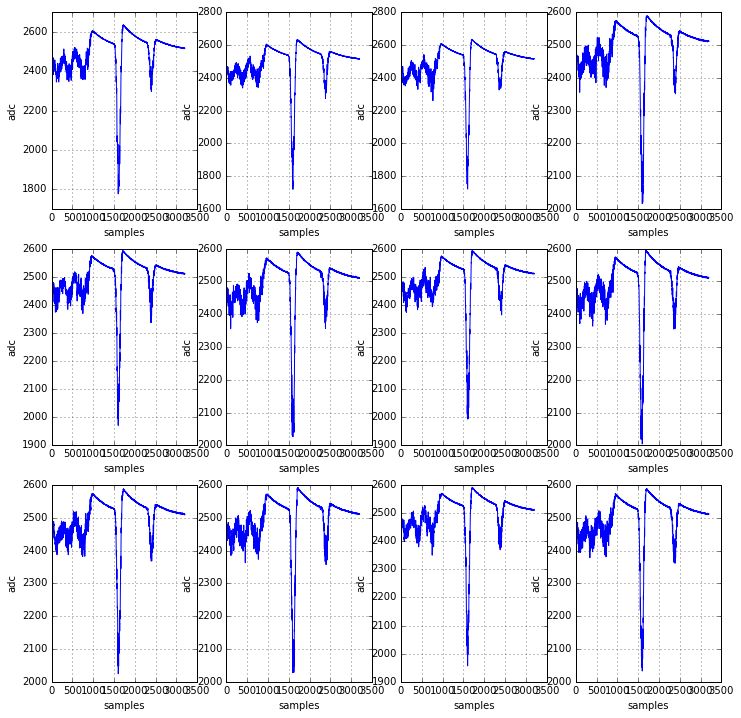

In [274]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=1600)

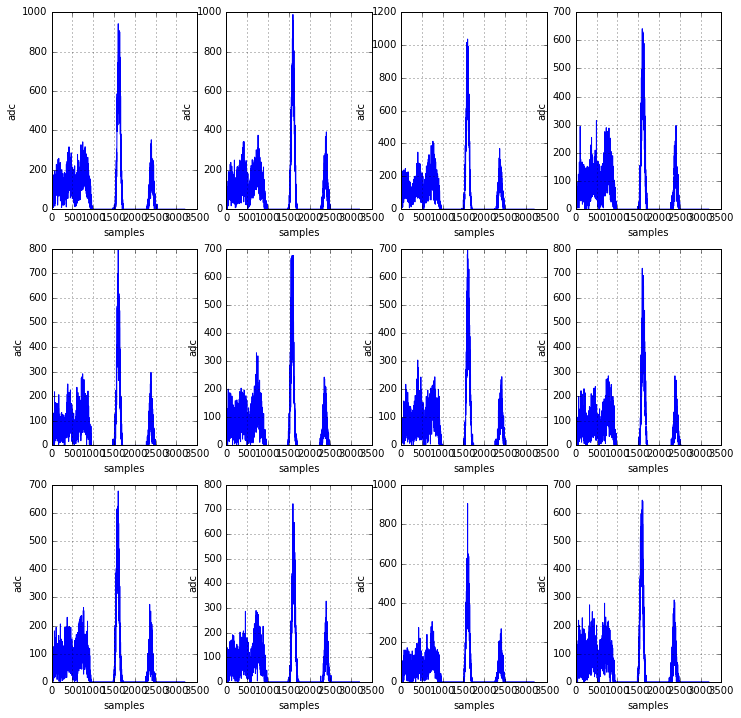

In [275]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=True, window_size=1600)

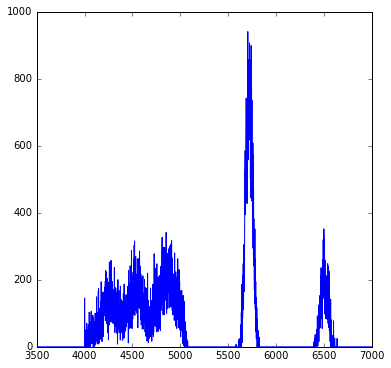

In [16]:
plt.figure(figsize=(6, 6))
xmin=3500
xmax=7000
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax])

event = 0
Input Energy = 214421.563923


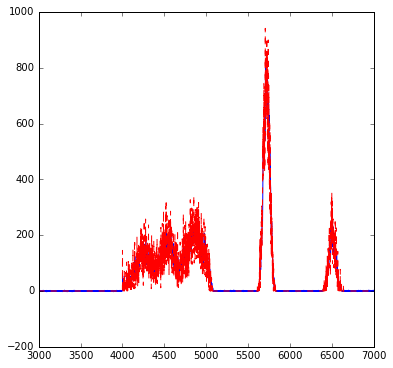

Reconstructed Energy = 214683.101409
Error in Energy Computation (%) = 0.121973499736
Press a key...


In [23]:
ER = blr_stats(e2500.root.pmtrd, event_list=range(1), xmin=3000, xmax=7000, pmtid=0, plot=True)

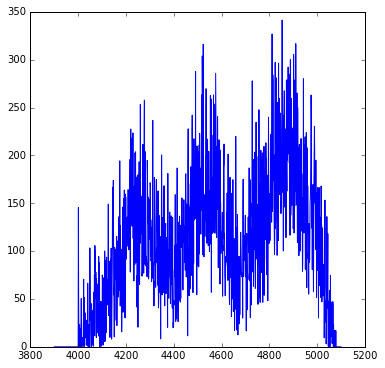

In [278]:
plt.figure(figsize=(6, 6))
xmin=3900
xmax=5100
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax])

event = 0
Input Energy = 123372.659574


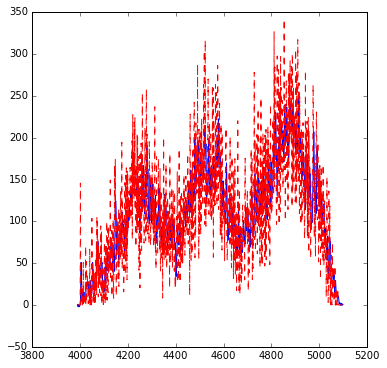

Reconstructed Energy = 123393.067229
Error in Energy Computation (%) = 0.0165414727441
Press a key...


In [279]:
ER = blr_stats(e2500.root.pmtrd, event_list=range(1), xmin=3990, xmax=5100, pmtid=0, plot=True)

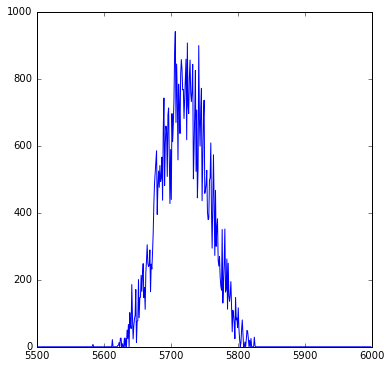

In [280]:
plt.figure(figsize=(6, 6))
xmin=5500
xmax=6000
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax])

event = 0
Input Energy = 70522.8913588


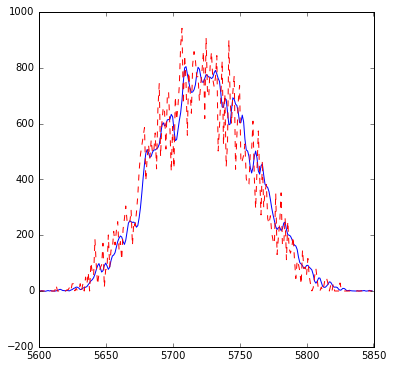

Reconstructed Energy = 70640.3982286
Error in Energy Computation (%) = 0.166622308859
Press a key...


In [281]:
ER = blr_stats(e2500.root.pmtrd, event_list=range(1), xmin=5600, xmax=5850, pmtid=0, plot=True)

#### Deconvolution seems to work very well in the MC

In [282]:
e2644 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2644.gdc1next.000.next1el_2644.root.h5','r+')

In [283]:
kr2609 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5','r+')

## Deconvolution in data

In [284]:
dataPMT

channel pmtid  active           x           y   coeff_c  coeff_blr  \
0         0     1       1  -23.941401   65.778503  0.000003   0.001632   
1        18     3       1  -44.995098  -53.623100  0.000003   0.001632   
2         1     2       1   68.936501  -12.155400  0.000003   0.001611   
3        19     4       1    0.000000  185.000000  0.000003   0.001599   
4        27     C       1 -118.916000  141.718002  0.000003   0.001567   
5        26     B       1 -182.188995   32.124901  0.000004   0.001650   
6         9     A       1 -160.214996  -92.500000  0.000003   0.001593   
7         8     9       1  -63.273701 -173.843002  0.000003   0.001612   
8        23     8       1   63.273701 -173.843002  0.000003   0.001601   
9        22     7       1  160.214996  -92.500000  0.000003   0.001593   
10        5     6       1  182.188995   32.124901  0.000003   0.001575   
11        4     5       1  118.916000  141.718002  0.000003   0.001596   

    adc_to_pes  noise_rms  
0     -22.9168     0.7060  
1     -23.7510     0.8744  
2     -25.3008     0.7213  
3     -25.9984     0.7624  
4     -23.7074     0.7921  
5     -20.8927     0.8660  
6     -22.1340     0.7062  
7     -33.0993     0.7278  
8     -20.4377     0.7303  
9     -25.1698     0.7160  
10    -15.8557     0.7323  
11    -18.2130     0.7206

In [192]:
dataPMT.coeff_blr.values

array([ 0.00163241,  0.00163241,  0.0016111 ,  0.00159936,  0.00156696,
        0.00164962,  0.00159296,  0.00161207,  0.00160068,  0.00159272,
        0.00157519,  0.00159632])

In [190]:
dataPMT.coeff_c.values

array([  2.90544700e-06,   3.08000000e-06,   2.80060000e-06,
         2.75626500e-06,   3.13876600e-06,   3.96517600e-06,
         2.71100000e-06,   3.12764100e-06,   3.06454300e-06,
         3.04046300e-06,   3.11360400e-06,   3.18597900e-06])

### Values from VHB (12-11-016)

pmtID = ['1','3','2','4',
         'C','B','A','9',
         '8','7','6','5']
elecID = [0, 18,  1, 19,  27, 26, 9,  8, 23, 22,  5,  4]
noise_rms = [0.7060,0.8744,0.7213,0.7624,
             0.7921,0.8660,0.7062,0.7278,
             0.7303,0.7160,0.7323,0.7206]
coef_c = [2.905447E-06,3.085705E-06,2.806061E-06,2.756265E-06,
          3.138766E-06,3.965176E-06,2.711644E-06,3.127641E-06,
          3.064543E-06,3.040463E-06,3.113604E-06,3.185979E-06]
coef_blr = [1.632411E-03,1.610050E-03,1.611104E-03,1.599356E-03,
            1.566958E-03,1.649618E-03,1.592963E-03,1.612068E-03,
            1.600683E-03,1.592718E-03,1.575192E-03,1.596322E-03]


### Kripton

In [285]:
pmtrwf = kr2609.root.RD.pmtrwf

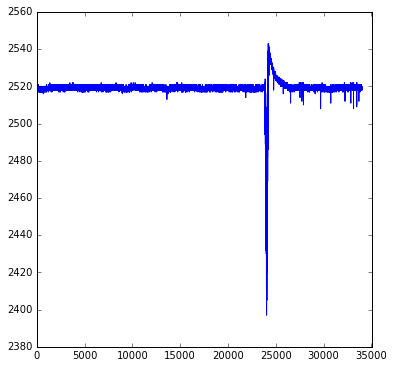

In [286]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=34000
plt.plot(range(xmin,xmax),pmtrwf[0,0][xmin:xmax])

In [288]:
event = 0
pmt = 0
BLR = blr.deconvolve_signal_acum(pmtrwf[event,pmt], n_baseline=500, 
                                 noise_rms=dataPMT.noise_rms[0],
                                 coef_clean=dataPMT.coeff_c[0], coef_blr=dataPMT.coeff_blr[0], 
                                 thr_trigger=5, thr_acum=700, coeff_acum = 0.9995,
                                 acum_discharge_length = 5000, acum_tau=2500, 
                                 acum_compress=0.01, filter_c=True)

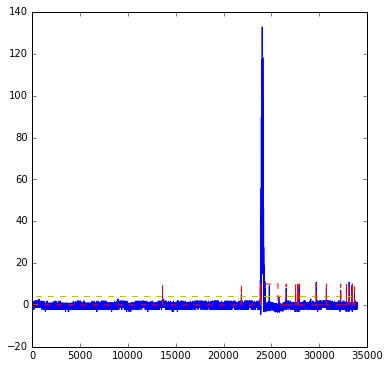

In [290]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=34000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

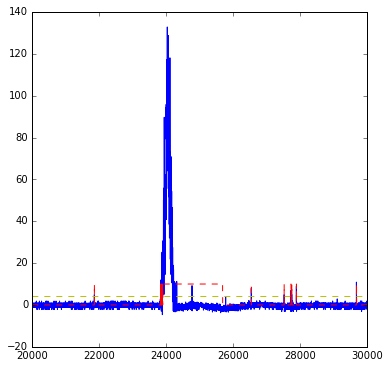

In [291]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

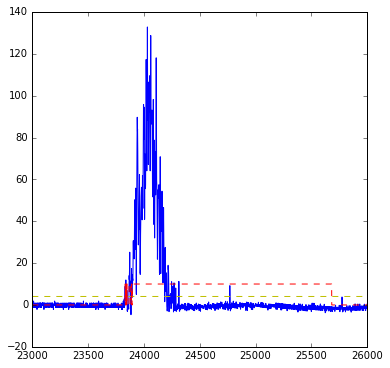

In [292]:
plt.figure(figsize=(6, 6))
xmin=23000
xmax=26000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

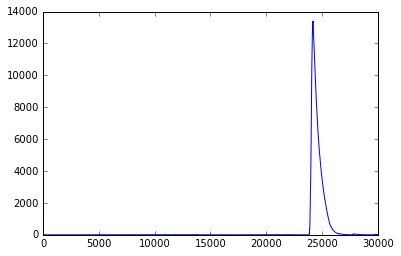

In [293]:
xmin=0
xmax=30000
plt.plot(range(xmin,xmax),BLR.acum[xmin:xmax])

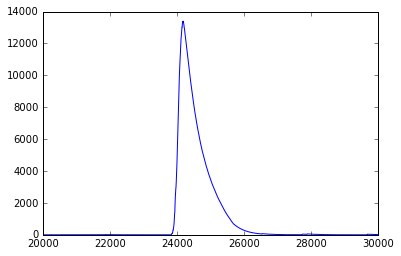

In [294]:
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),BLR.acum[xmin:xmax])

In [335]:
pmtrwf = e2644.root.RD.pmtrwf

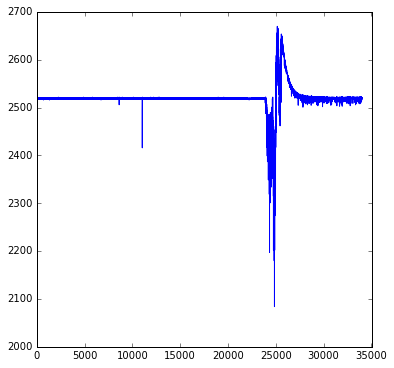

In [296]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=34000
plt.plot(range(xmin,xmax),pmtrwf[0,0][xmin:xmax])

In [298]:
event = 0
pmt = 0
BLR = blr.deconvolve_signal_acum(pmtrwf[event,pmt], n_baseline=500, 
                                 noise_rms=dataPMT.noise_rms[0],
                                 coef_clean=dataPMT.coeff_c[0], coef_blr=dataPMT.coeff_blr[0], 
                                 thr_trigger=5, thr_acum=700, coeff_acum = 0.9995,
                                 acum_discharge_length = 5000, acum_tau=2500, 
                                 acum_compress=0.01, filter_c=True)

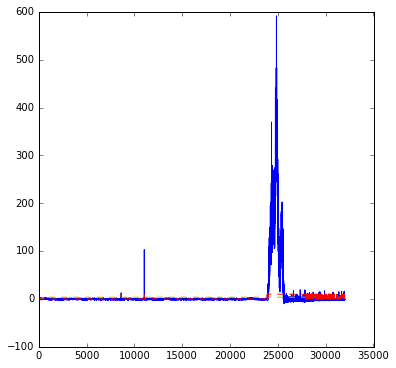

In [299]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=32000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

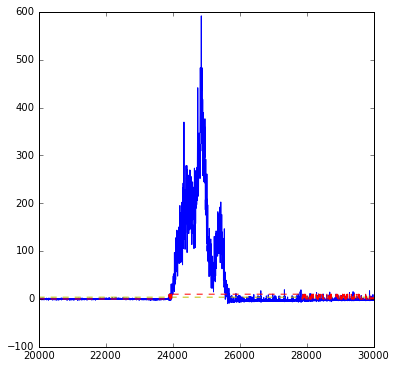

In [300]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

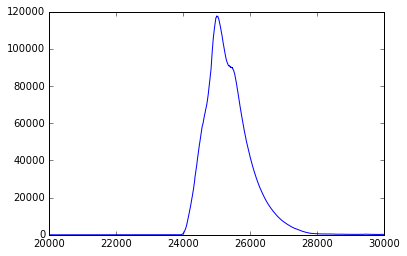

In [301]:
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),BLR.acum[xmin:xmax])

In [332]:
def deconv_pmt(pmtrwf, event=0):
    """
    Deconvolution of all the PMTs in the event
    """
    NPMT = pmtrwf.shape[1]
    PMTR = {}
    for pmt in range(NPMT):
        BLR = blr.deconvolve_signal_acum(pmtrwf[event,pmt], n_baseline=500, 
                                 noise_rms=dataPMT.noise_rms[pmt],
                                 coef_clean=dataPMT.coeff_c[pmt], 
                                 coef_blr=dataPMT.coeff_blr[pmt], 
                                 thr_trigger=5, thr_acum=700, coeff_acum = 0.991,
                                 acum_discharge_length = 5000, acum_tau=2500, 
                                 acum_compress=0.01, filter_c=True)
        PMTR[pmt] = BLR.signal_r
    return pd.DataFrame(PMTR)
        

In [337]:
pmtcwf = deconv_pmt(pmtrwf, event=0)

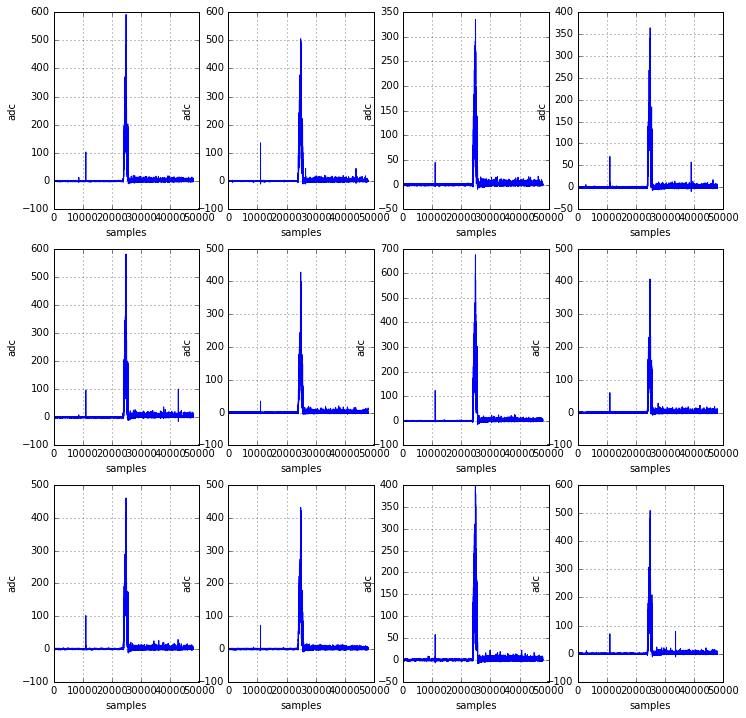

In [340]:
mpl.plot_waveforms(pmtcwf, maxlen=0, zoom=False, window_size=1600)

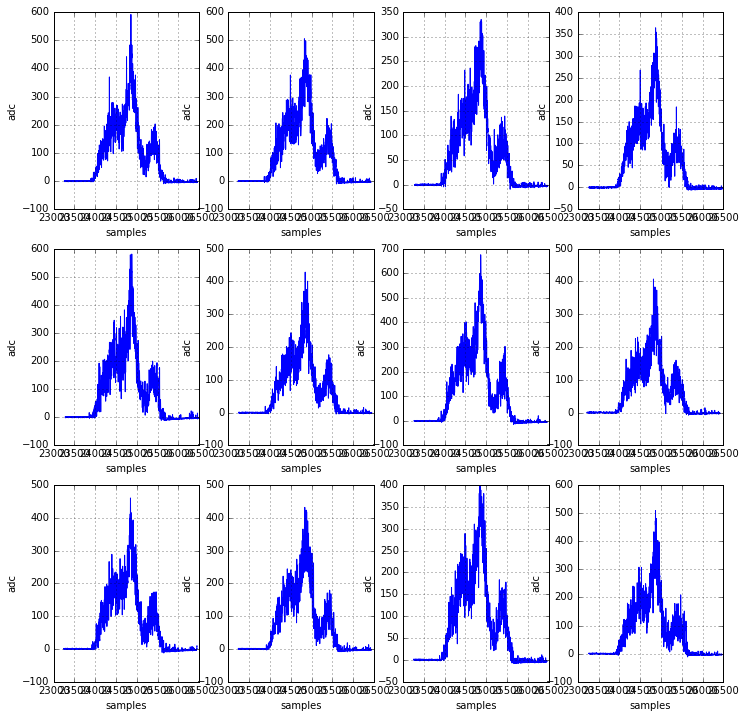

In [342]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=0), maxlen=0, zoom=True, window_size=1600)

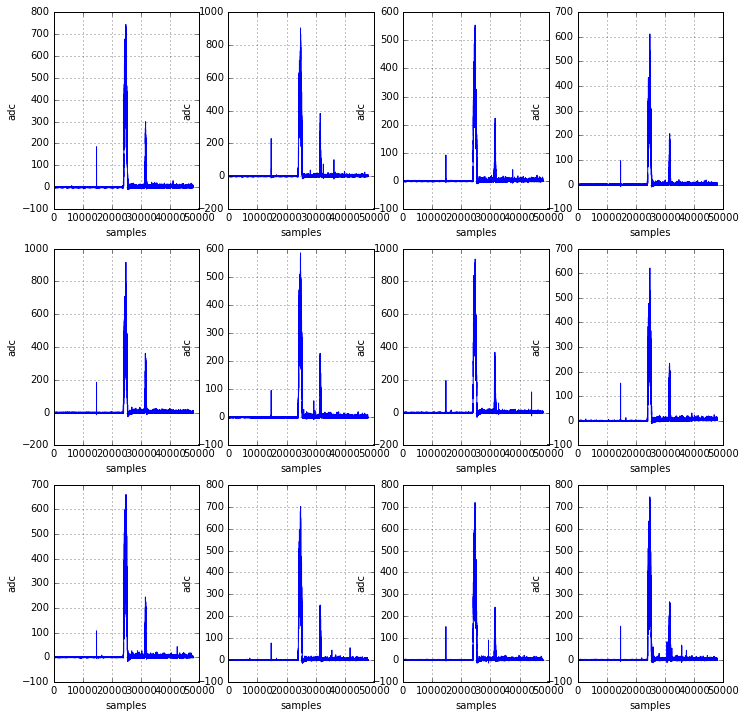

In [343]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=1), maxlen=0, zoom=False, window_size=1600)

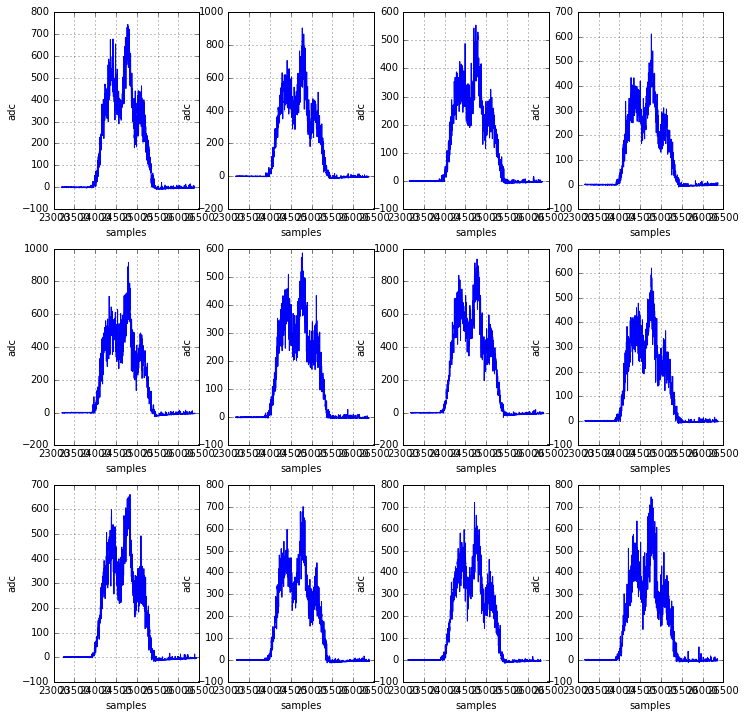

In [344]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=1), maxlen=0, zoom=True, window_size=1600)

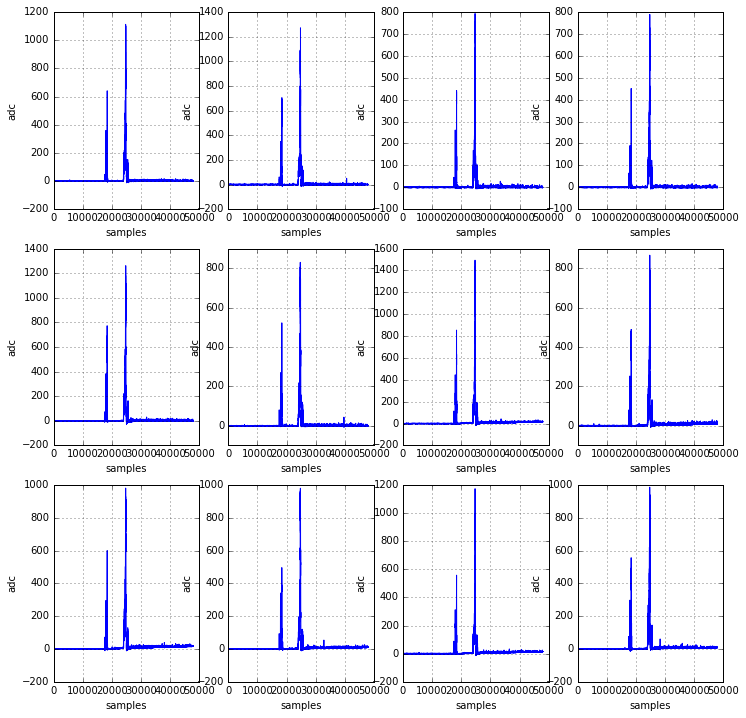

In [345]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=2), maxlen=0, zoom=False, window_size=1600)

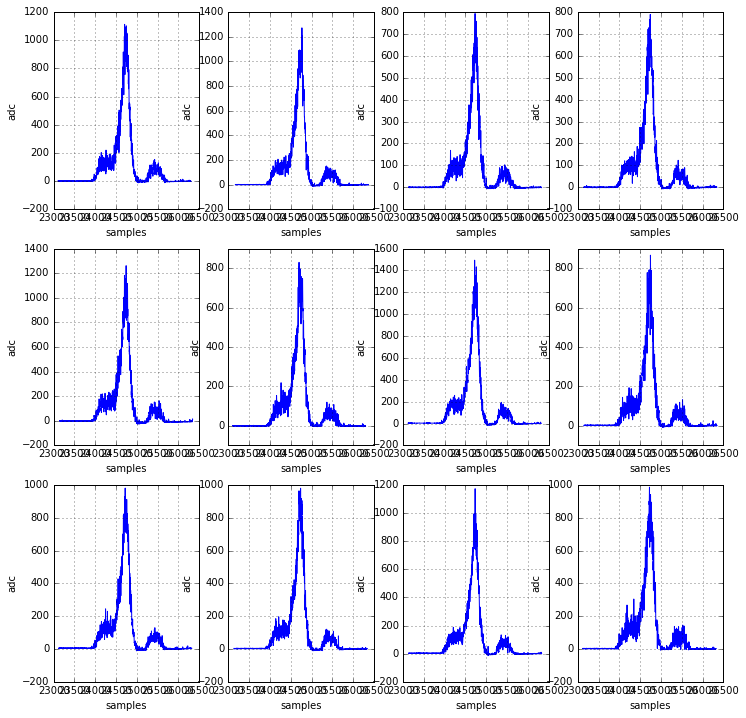

In [346]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=2), maxlen=0, zoom=True, window_size=1600)

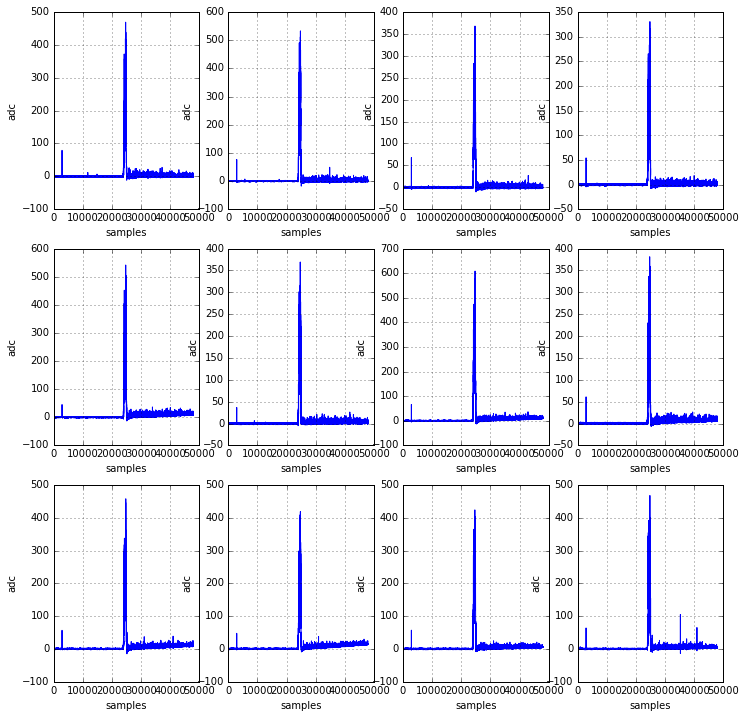

In [347]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=3), maxlen=0, zoom=False, window_size=1600)

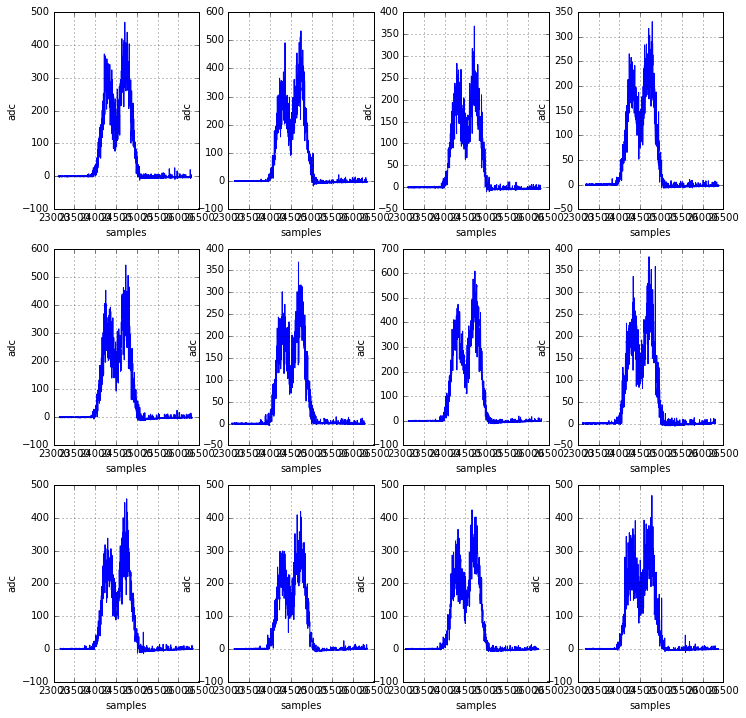

In [348]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=3), maxlen=0, zoom=True, window_size=1600)

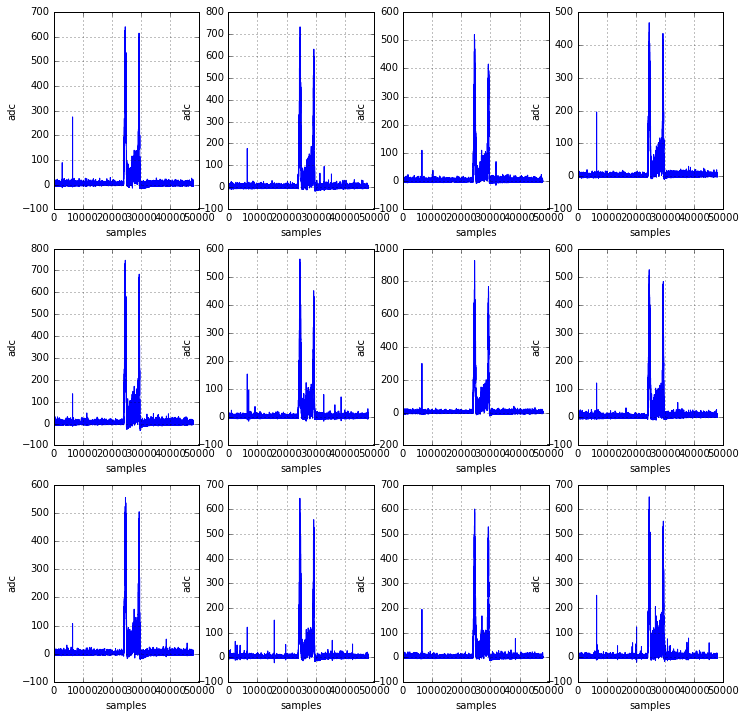

In [349]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=4), maxlen=0, zoom=False, window_size=1600)

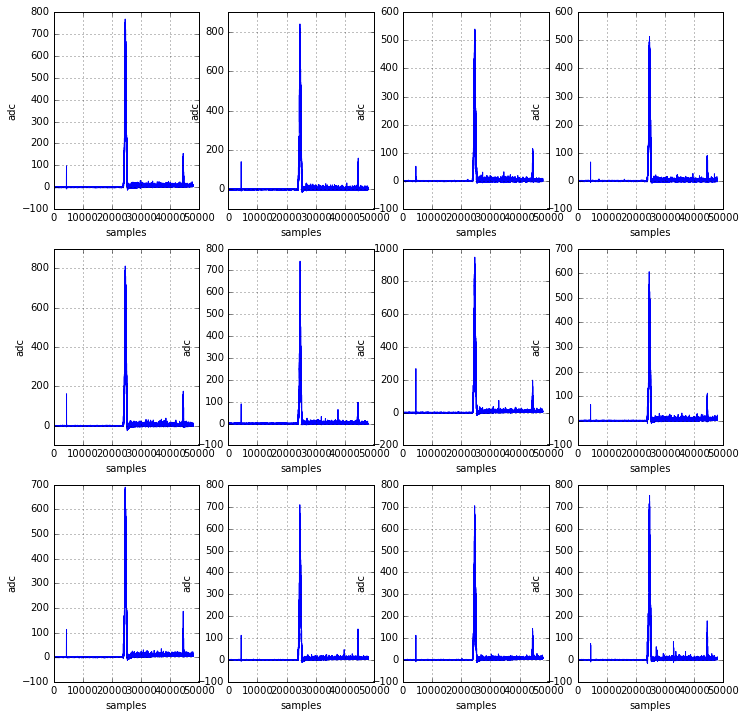

In [350]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=5), maxlen=0, zoom=False, window_size=1600)

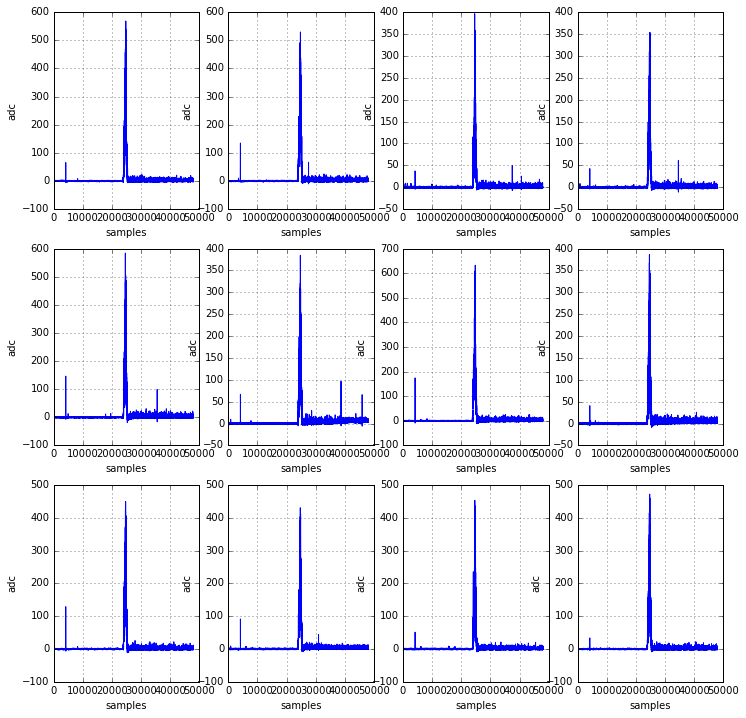

In [351]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=6), maxlen=0, zoom=False, window_size=1600)

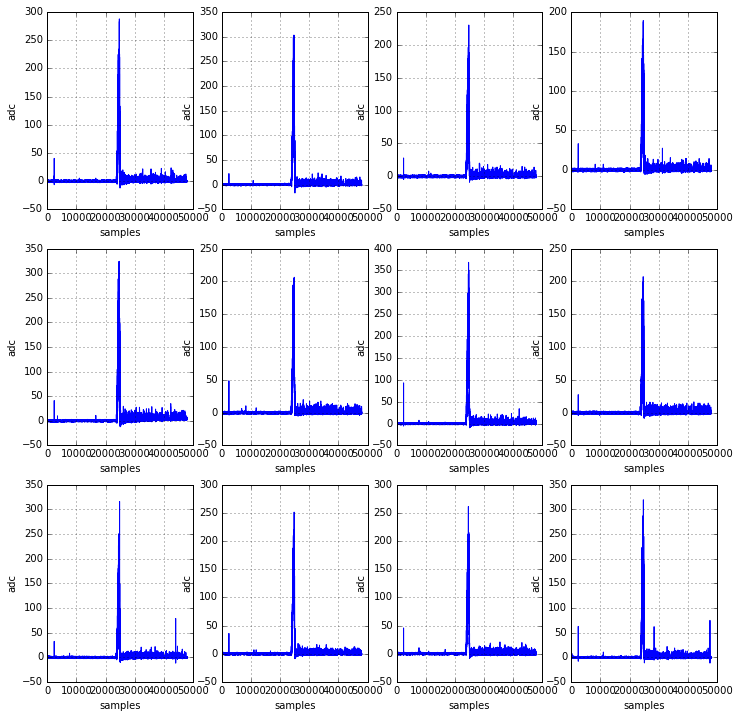

In [352]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=7), maxlen=0, zoom=False, window_size=1600)

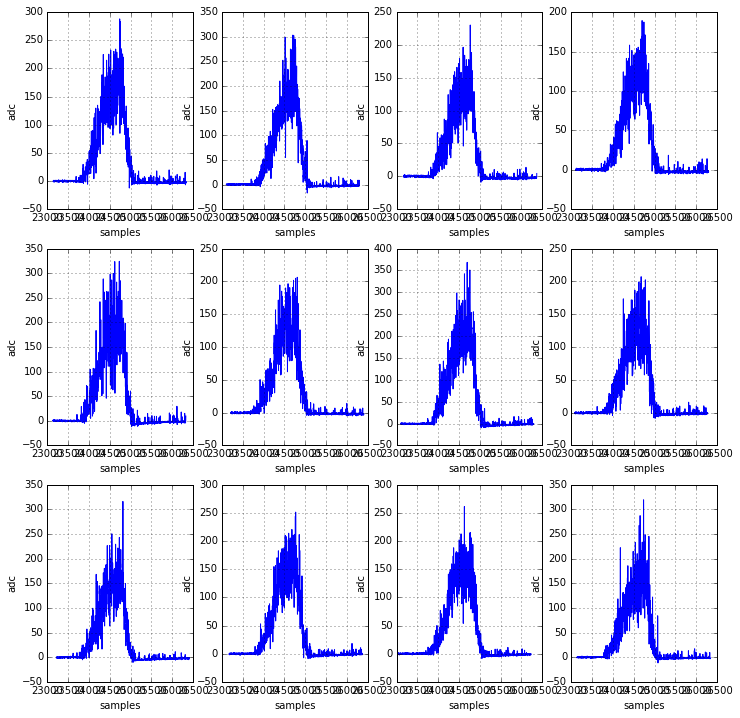

In [353]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=7), maxlen=0, zoom=True, window_size=1600)

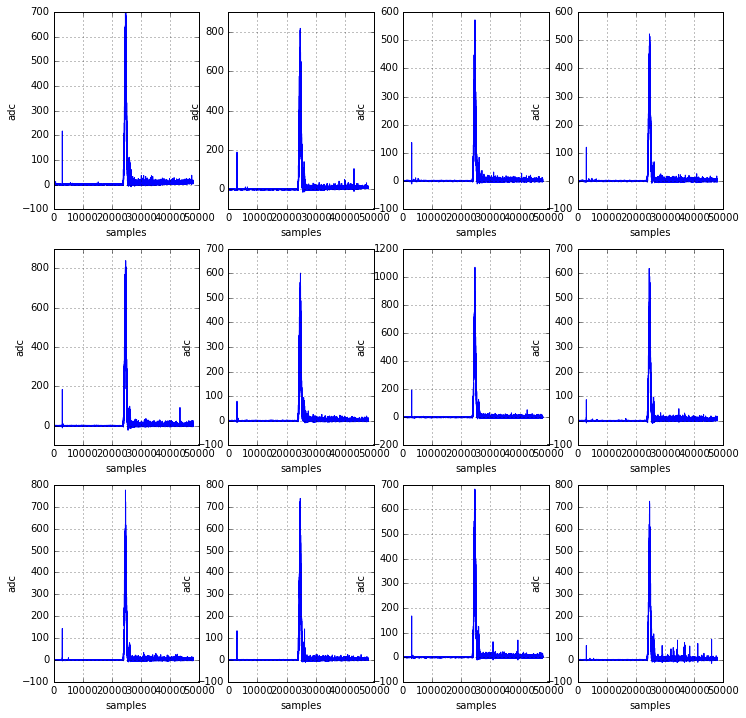

In [354]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=8), maxlen=0, zoom=False, window_size=1600)

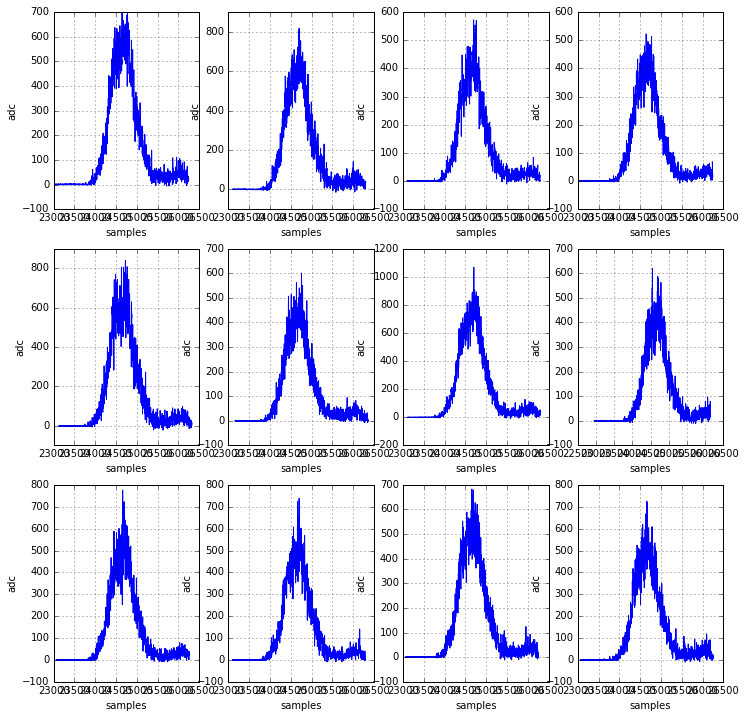

In [355]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=8), maxlen=0, zoom=True, window_size=1600)

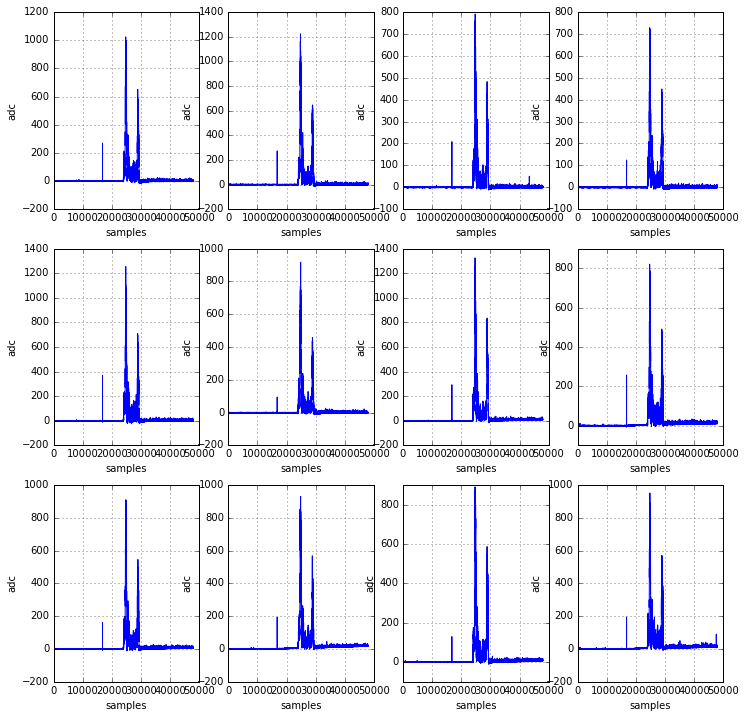

In [356]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=9), maxlen=0, zoom=False, window_size=1600)

#### Deconv robust for data electrons!

In [357]:
pmtrwf = kr2609.root.RD.pmtrwf

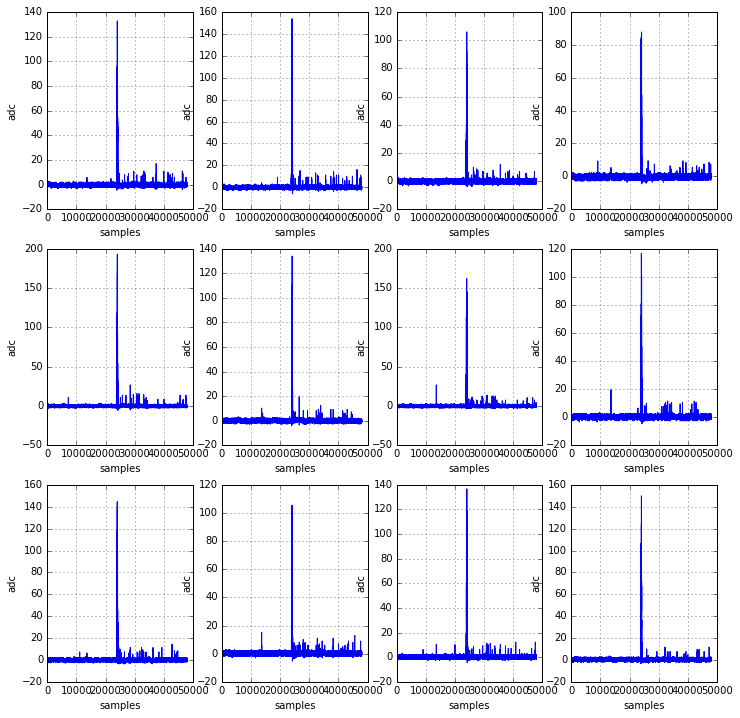

In [358]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=0), maxlen=0, zoom=False, window_size=1600)

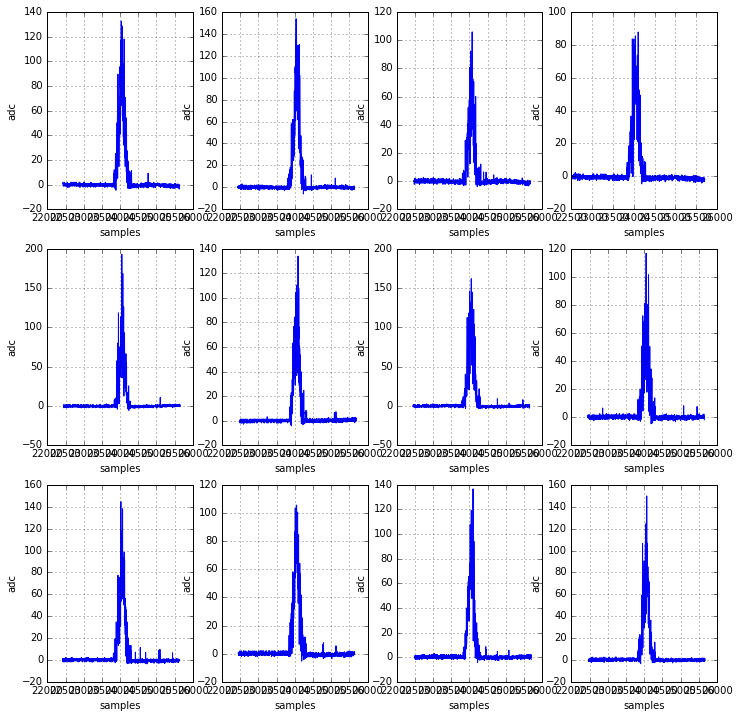

In [359]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=0), maxlen=0, zoom=True, window_size=1600)

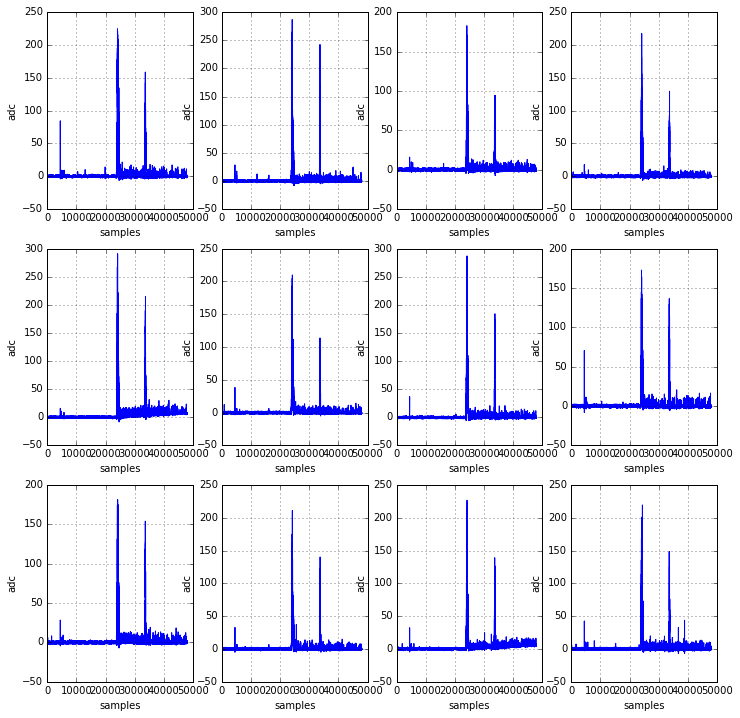

In [360]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=1), maxlen=0, zoom=False, window_size=1600)

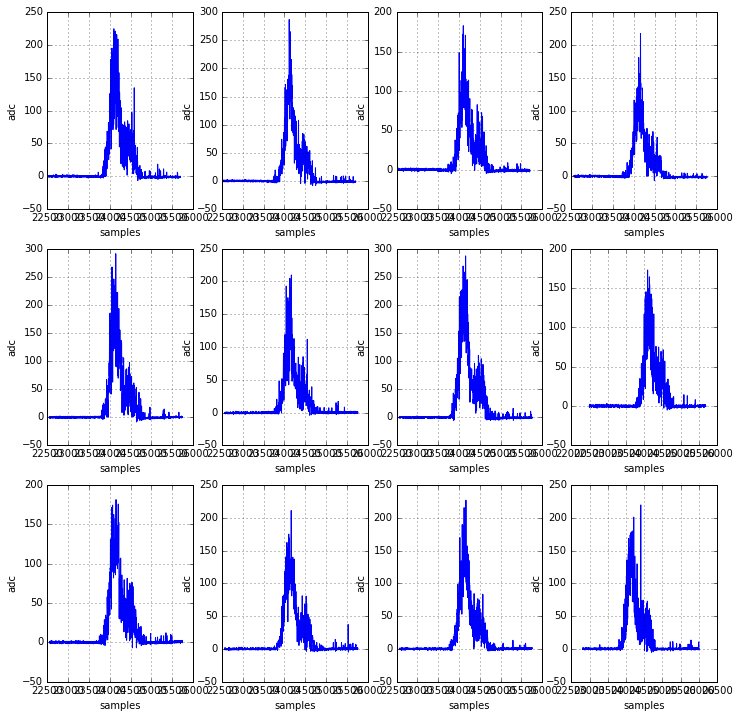

In [361]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=1), maxlen=0, zoom=True, window_size=1600)

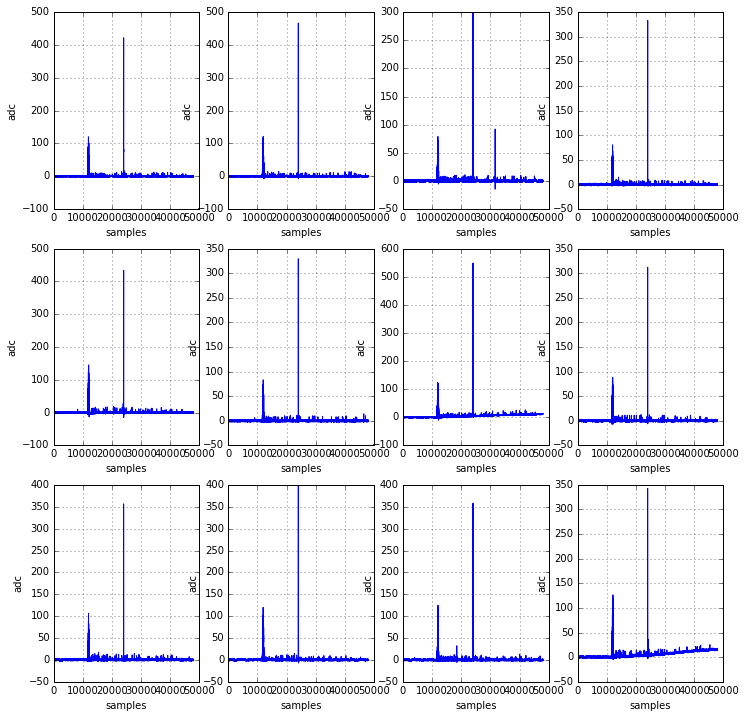

In [362]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=2), maxlen=0, zoom=False, window_size=1600)

In [369]:
BLR = blr.deconvolve_signal_acum(pmtrwf[2,11], n_baseline=500, 
                                 noise_rms=dataPMT.noise_rms[pmt],
                                 coef_clean=dataPMT.coeff_c[pmt], 
                                 coef_blr=dataPMT.coeff_blr[pmt], 
                                 thr_trigger=5, thr_acum=700, coeff_acum = 0.991,
                                 acum_discharge_length = 5000, acum_tau=2500, 
                                 acum_compress=0.01, filter_c=True)

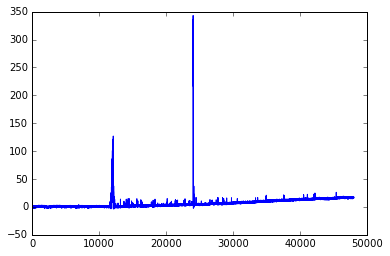

In [370]:
plt.plot(BLR.signal_r)

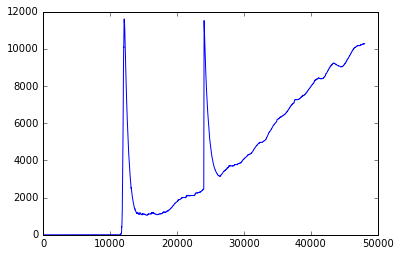

In [371]:
plt.plot(BLR.acum)

#### Voila! A pretty example of a situation in which you need to discharge the accumulator, starting at a value higher than ~1 lsb. See how this can be fixed!

In [372]:
BLR = blr.deconvolve_signal_acum(pmtrwf[2,11], n_baseline=500, 
                                 noise_rms=dataPMT.noise_rms[pmt],
                                 coef_clean=dataPMT.coeff_c[pmt], 
                                 coef_blr=dataPMT.coeff_blr[pmt], 
                                 thr_trigger=5, thr_acum=2000, coeff_acum = 0.991,
                                 acum_discharge_length = 5000, acum_tau=2500, 
                                 acum_compress=0.01, filter_c=True)

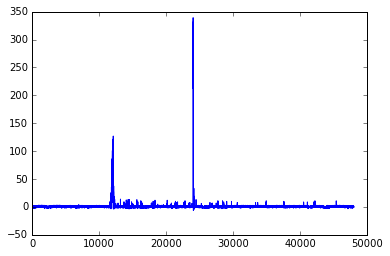

In [373]:
plt.plot(BLR.signal_r)

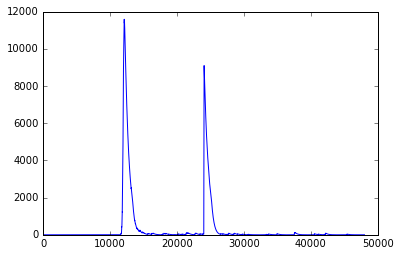

In [374]:
plt.plot(BLR.acum)

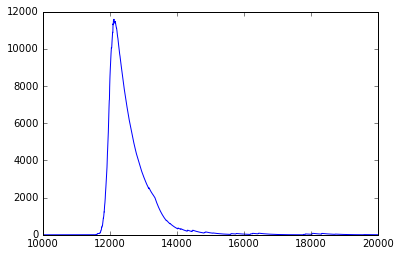

In [375]:
plt.plot(BLR.acum[10000:20000])

#### Fixed! Discharge function is a good thing!

In [376]:
def deconv_pmt(pmtrwf, event=0):
    """
    Deconvolution of all the PMTs in the event
    """
    NPMT = pmtrwf.shape[1]
    PMTR = {}
    for pmt in range(NPMT):
        BLR = blr.deconvolve_signal_acum(pmtrwf[event,pmt], n_baseline=500, 
                                 noise_rms=dataPMT.noise_rms[pmt],
                                 coef_clean=dataPMT.coeff_c[pmt], 
                                 coef_blr=dataPMT.coeff_blr[pmt], 
                                 thr_trigger=5, thr_acum=2000, coeff_acum = 0.991,
                                 acum_discharge_length = 5000, acum_tau=2500, 
                                 acum_compress=0.01, filter_c=True)
        PMTR[pmt] = BLR.signal_r
    return pd.DataFrame(PMTR)

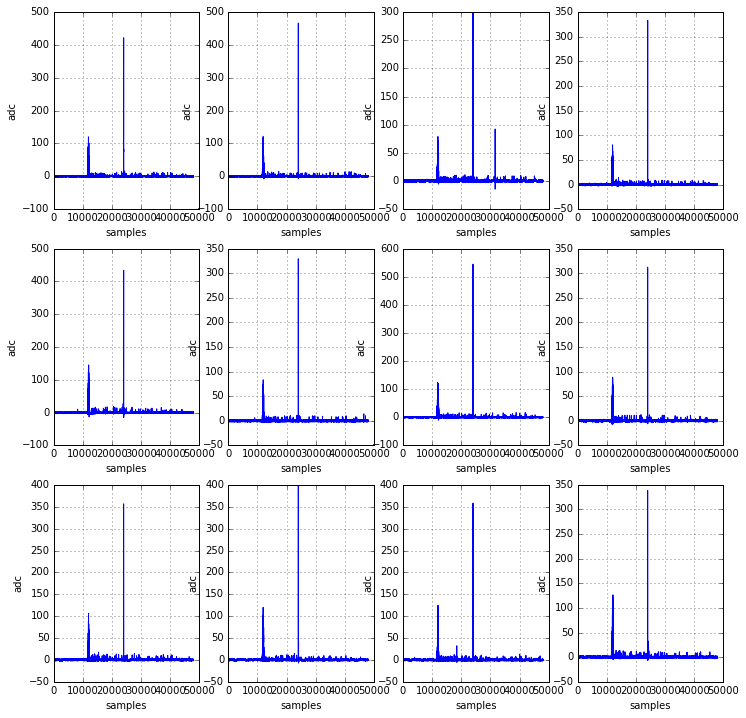

In [377]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=2), maxlen=0, zoom=False, window_size=1600)

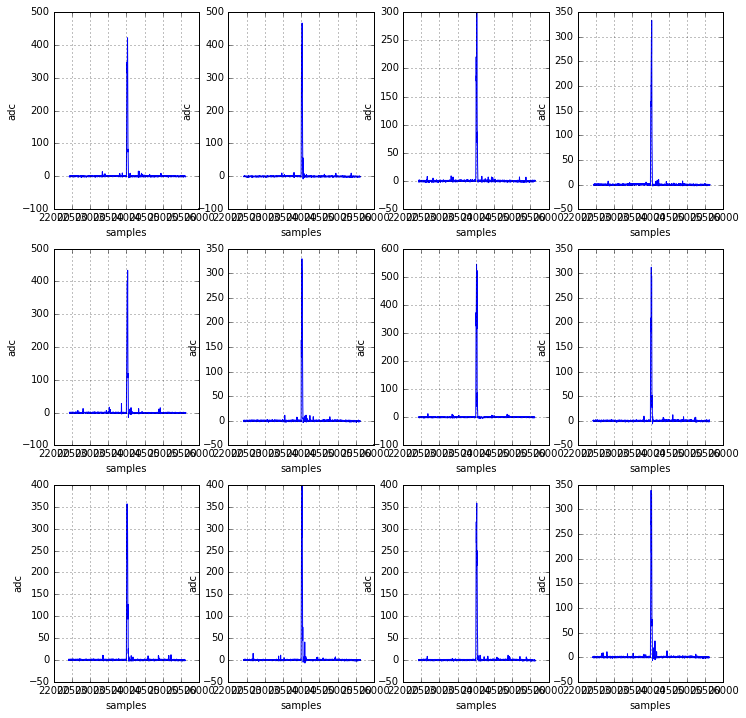

In [378]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=2), maxlen=0, zoom=True, window_size=1600)

#### NB, this best is not a kripton. 

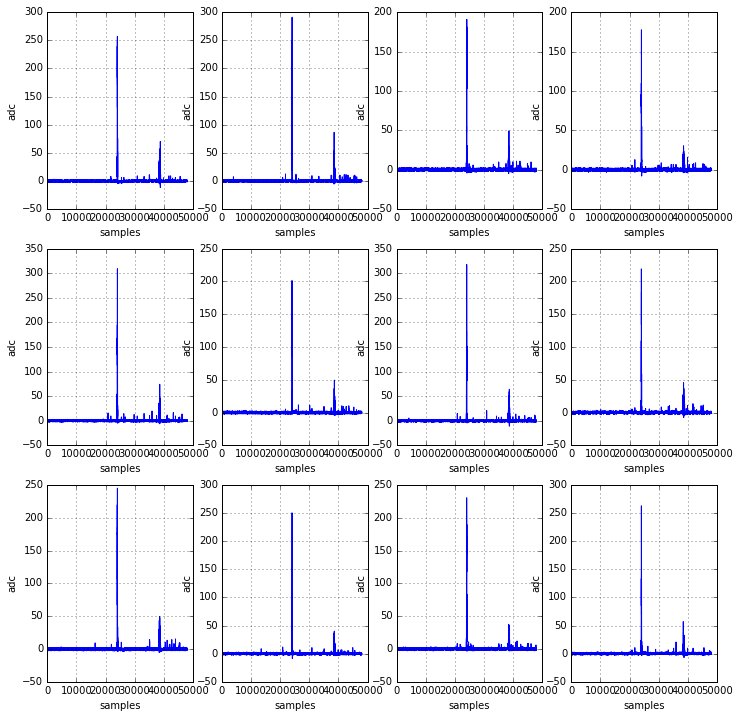

In [379]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=3), maxlen=0, zoom=False, window_size=1600)

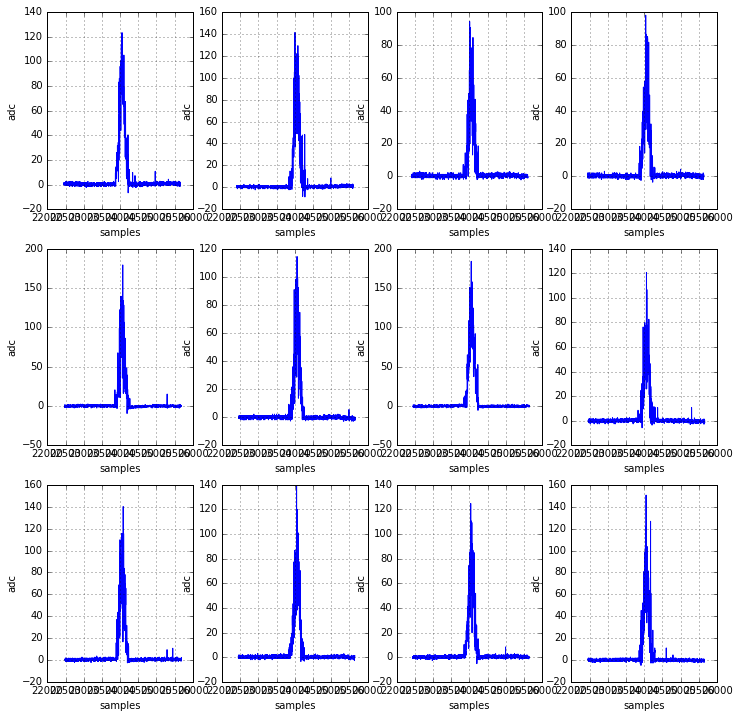

In [380]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=4), maxlen=0, zoom=True, window_size=1600)

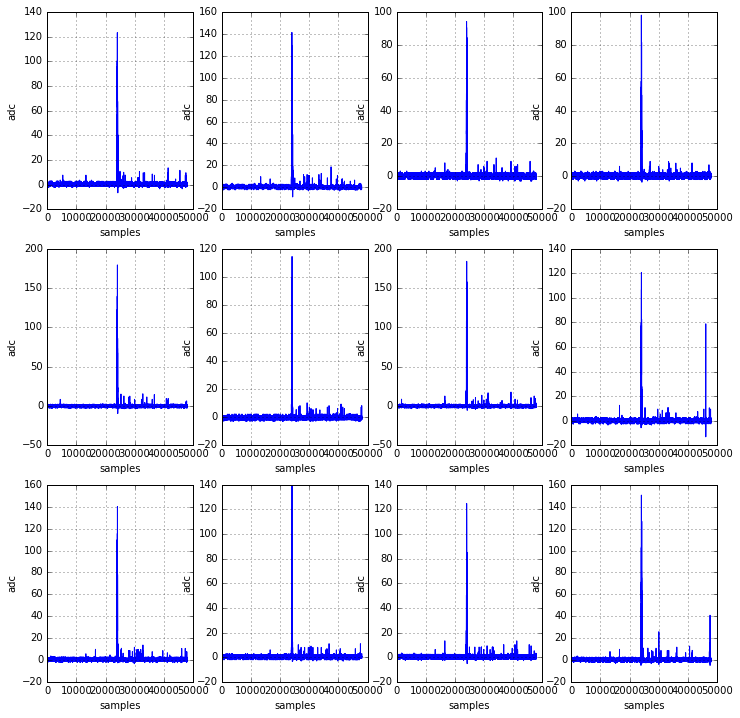

In [381]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=4), maxlen=0, zoom=False, window_size=1600)

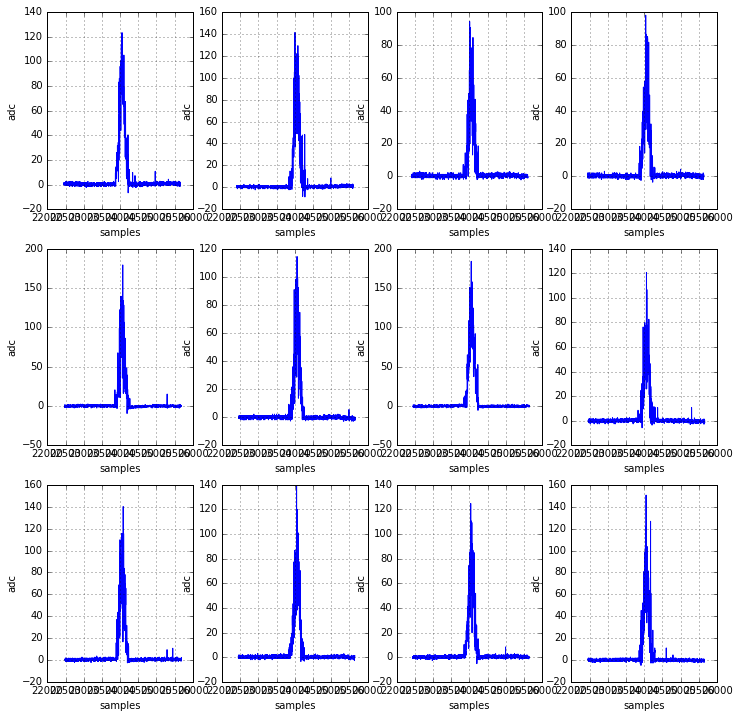

In [382]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=4), maxlen=0, zoom=True, window_size=1600)

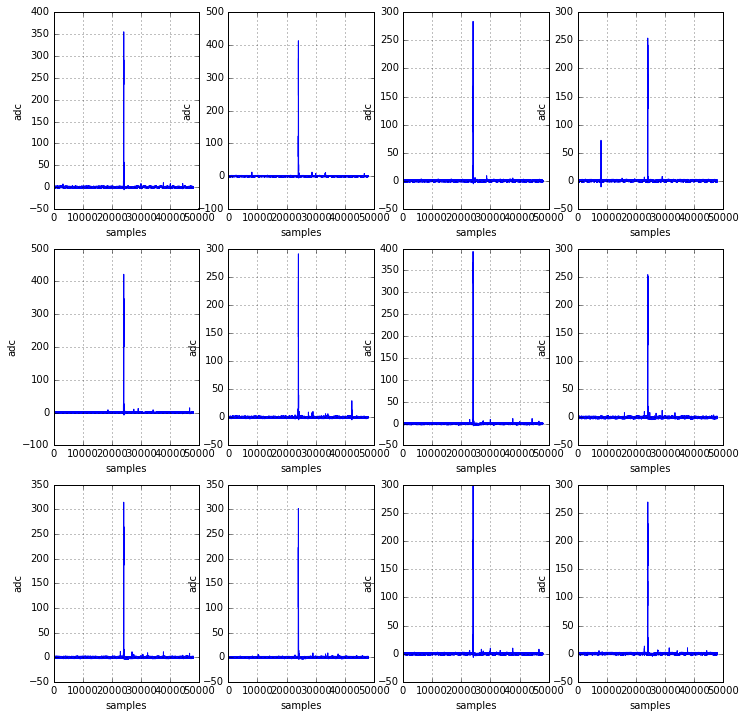

In [383]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=5), maxlen=0, zoom=False, window_size=1600)

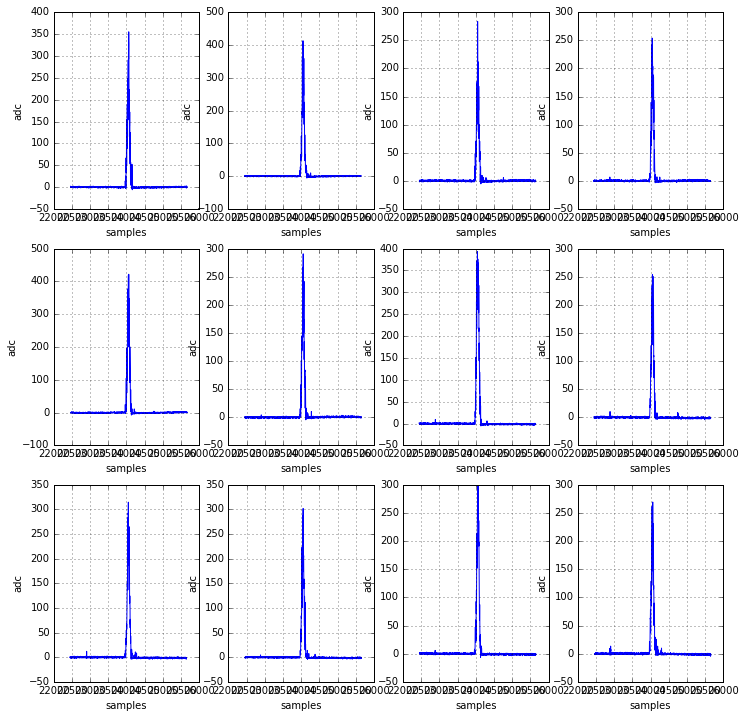

In [384]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=5), maxlen=0, zoom=True, window_size=1600)

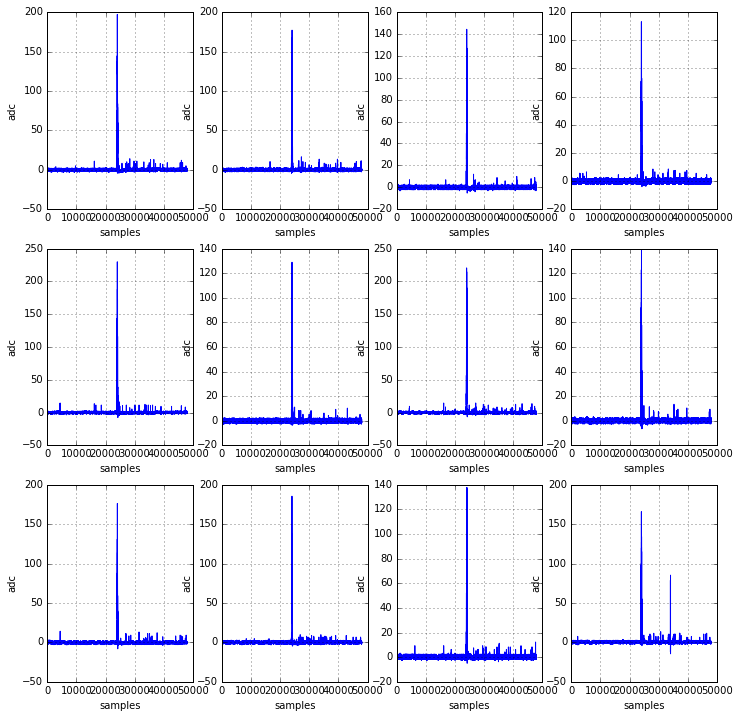

In [385]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=6), maxlen=0, zoom=False, window_size=1600)

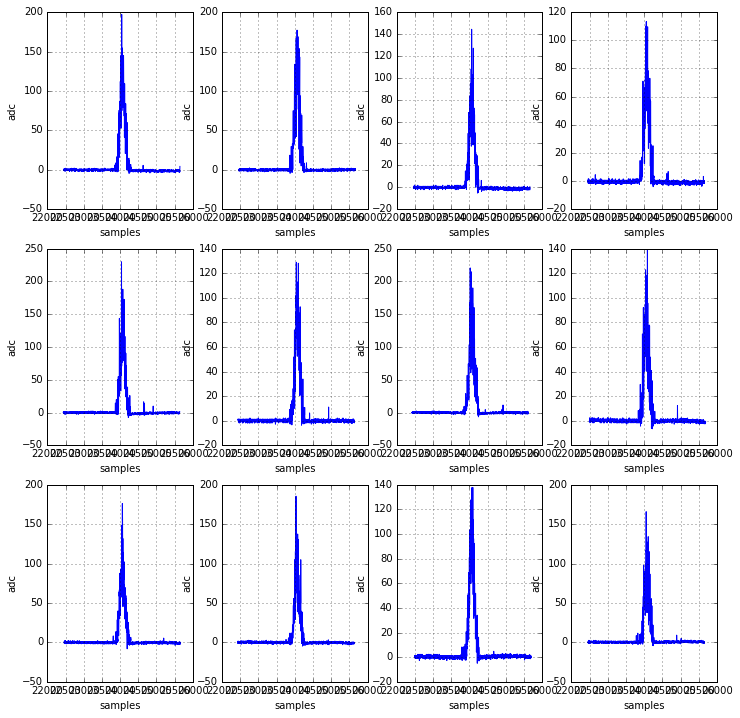

In [386]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=6), maxlen=0, zoom=True, window_size=1600)

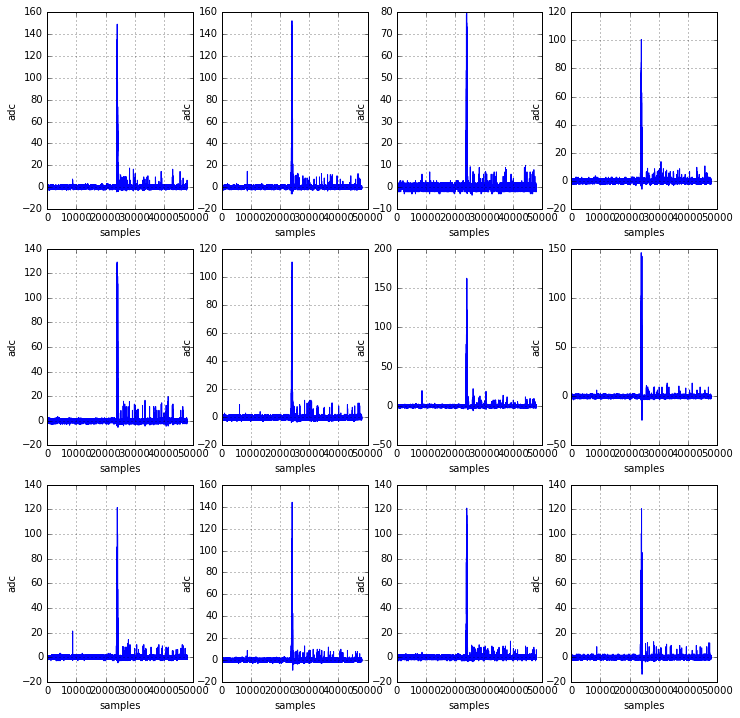

In [387]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=7), maxlen=0, zoom=False, window_size=1600)

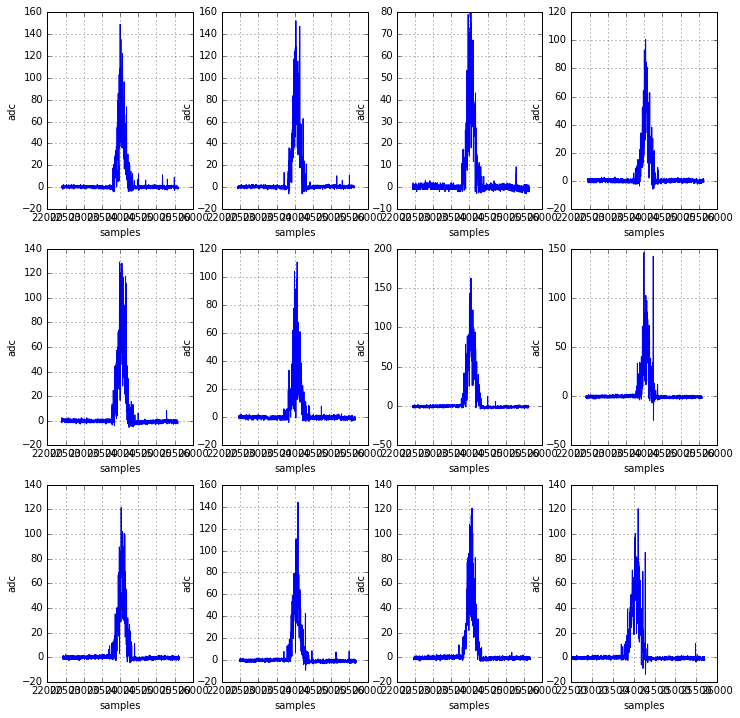

In [388]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=7), maxlen=0, zoom=True, window_size=1600)

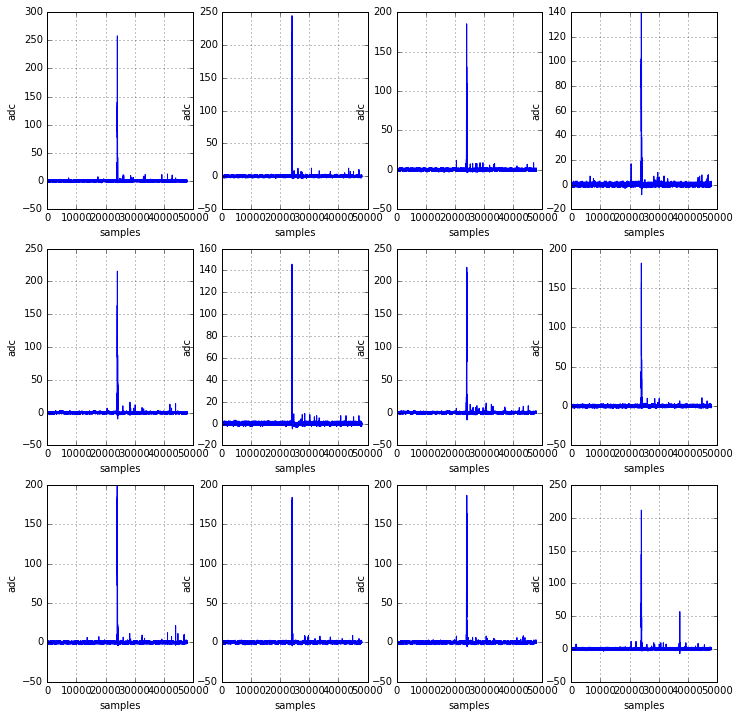

In [389]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=8), maxlen=0, zoom=False, window_size=1600)

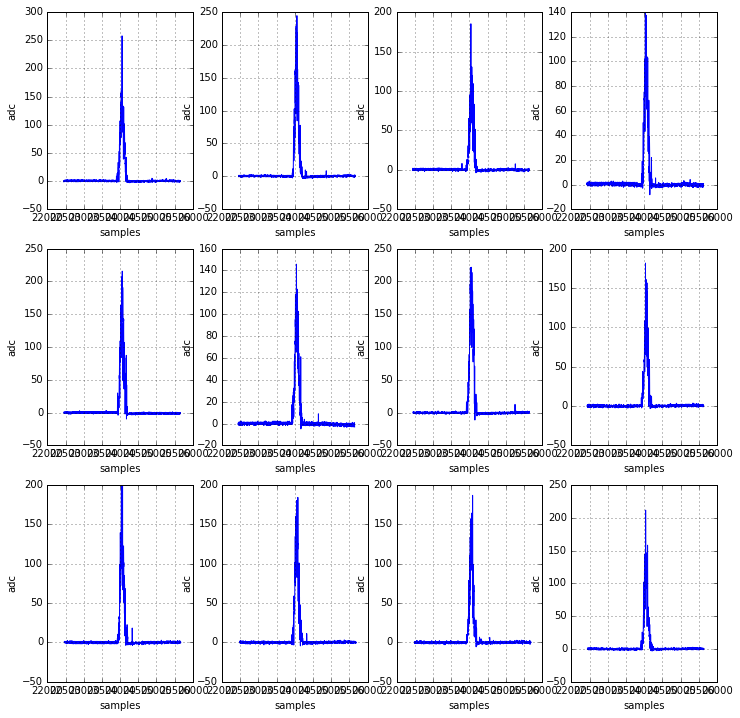

In [390]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=8), maxlen=0, zoom=True, window_size=1600)

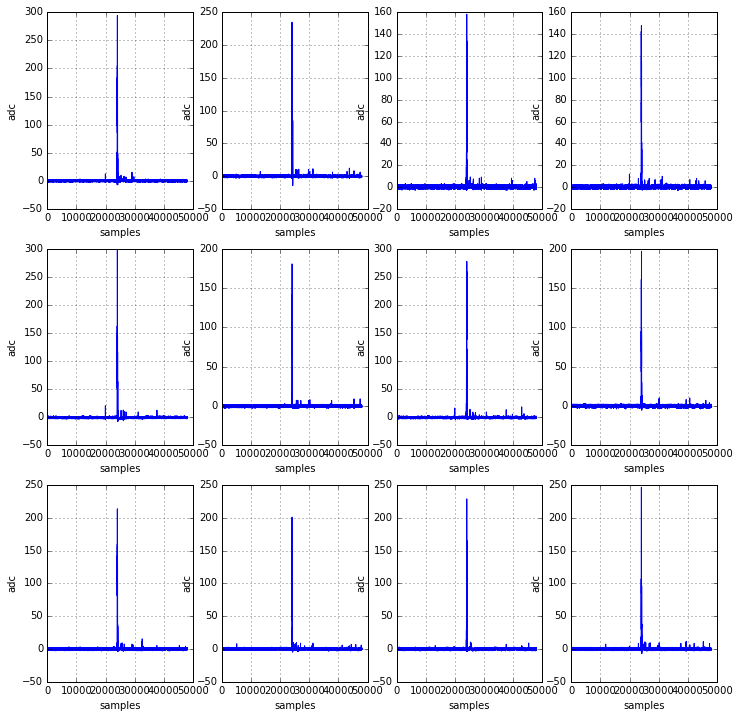

In [391]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=9), maxlen=0, zoom=False, window_size=1600)

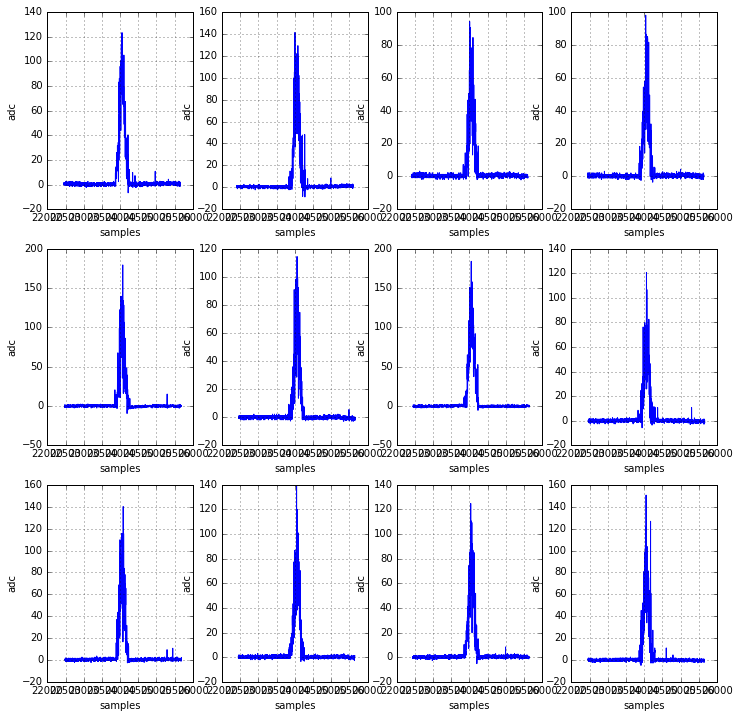

In [392]:
mpl.plot_waveforms(deconv_pmt(pmtrwf, event=4), maxlen=0, zoom=True, window_size=1600)

#### Seems to work! Bravo Master Herrero!

In [29]:
p = 15.
r = p/np.sqrt(12.)
r

4.3301270189221936

In [26]:
r


0.28867513459481292

In [30]:
4.3/3.

1.4333333333333333